# Environment preparations

In [1]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# Prepare dataset
!cp -r /content/drive/MyDrive/dataset /content/
!cp -r /content/drive/MyDrive/HW2 /content/
!cp -r /content/drive/MyDrive/outputs /content/
!unzip dataset/models.zip -d ./
!unzip dataset/testing_data_pose.zip -d ./
!unzip dataset/training_data.zip -d ./



流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: ./training_data_filtered/training_data/v2.2/1-6-0_meta.pkl  
  inflating: ./training_data_filtered/training_data/v2.2/2-168-12_label_kinect.png  
  inflating: ./training_data_filtered/training_data/v2.2/2-29-2_color_kinect.png  
  inflating: ./training_data_filtered/training_data/v2.2/1-84-0_meta.pkl  
  inflating: ./training_data_filtered/training_data/v2.2/2-213-38_meta.pkl  
  inflating: ./training_data_filtered/training_data/v2.2/2-209-30_color_kinect.png  
  inflating: ./training_data_filtered/training_data/v2.2/2-45-9_meta.pkl  
  inflating: ./training_data_filtered/training_data/v2.2/2-35-17_color_kinect.png  
  inflating: ./training_data_filtered/training_data/v2.2/1-47-1_label_kinect.png  
  inflating: ./training_data_filtered/training_data/v2.2/1-54-6_depth_kinect.png  
  inflating: ./training_data_filtered/training_data/v2.2/2-28-34_depth_kinect.png  
  inflating: ./training_data_filtered/training_data/v2.2/1-53-1_meta.pkl  
  inflatin

# Training data Loading

In [3]:
!pip install utils
!pip install open3d

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 420.5/420.5 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 93.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 85.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 79.7 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.6
    Uninstalling widgetsnbextension-3.6.6:
      Successfully uninstalled widgetsnbextension-3.6.6
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1
  Attempting uninstall: nbformat
    Found existing installation: nbformat 5.9.2
    Uninstalling nbformat-5.9.2:
      Successfully uninstalled nb

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import pickle
import utils

def load_pickle(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)



In [5]:
training_data_root = "./training_data_filtered/training_data"
training_data_dir = "./training_data_filtered/training_data/v2.2"
split_dir = "./training_data_filtered/training_data/splits/v2"


In [6]:
"""Visualization utilies."""

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def show_points(points, title):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.set_title(title)
    ax.set_xlim3d([-2, 2])
    ax.set_ylim3d([-2, 2])
    ax.set_zlim3d([0, 4])
    ax.scatter(points[:, 0], points[:, 2], points[:, 1])

def compare_points(points1, points2):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.set_xlim3d([-2, 2])
    ax.set_ylim3d([-2, 2])
    ax.set_zlim3d([0, 4])
    ax.scatter(points1[:, 0], points1[:, 2], points1[:, 1])
    ax.scatter(points2[:, 0], points2[:, 2], points2[:, 1])

In [7]:
"""Metric and visualization."""

def compute_rre(R_est: np.ndarray, R_gt: np.ndarray):
    """Compute the relative rotation error (geodesic distance of rotation)."""
    assert R_est.shape == (3, 3), 'R_est: expected shape (3, 3), received shape {}.'.format(R_est.shape)
    assert R_gt.shape == (3, 3), 'R_gt: expected shape (3, 3), received shape {}.'.format(R_gt.shape)
    # relative rotation error (RRE)
    # Rotational degree loss (not objective of optimization)
    rre = np.arccos(np.clip(0.5 * (np.trace(R_est.T @ R_gt) - 1), -1.0, 1.0))
    return rre


def compute_rte(t_est: np.ndarray, t_gt: np.ndarray):
    assert t_est.shape == (3,), 't_est: expected shape (3,), received shape {}.'.format(t_est.shape)
    assert t_gt.shape == (3,), 't_gt: expected shape (3,), received shape {}.'.format(t_gt.shape)
    # relative translation error (RTE)
    rte = np.linalg.norm(t_est - t_gt) # Resembling MSE loss
    return rte




In [8]:
def get_train_split_files(split_name):
    with open(os.path.join(split_dir, f"{split_name}.txt"), 'r') as f:
        prefixIds = [line.strip() for line in f if line.strip()]
        prefix = [os.path.join(training_data_dir, line) for line in prefixIds]
        # prefix = [os.path.join(training_data_dir, line.strip()) for line in f if line.strip()]
        rgb = [p + "_color_kinect.png" for p in prefix]
        depth = [p + "_depth_kinect.png" for p in prefix]
        label = [p + "_label_kinect.png" for p in prefix]
        meta = [p + "_meta.pkl" for p in prefix]
    return rgb, depth, label, meta, prefixIds


[35 39 48 51 58]
['jenga', 'master_chef_can', 'potted_meat_can', 'pudding_box', 'wood_block']
./training_data_filtered/training_data/v2.2/1-1-4_label_kinect.png
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, array([1., 1., 1.], dtype=float32), None, None, None, array([0.5, 0.5, 0.5], dtype=float32), None, None, None, None, None, None, None, None, array([1., 1., 1.], dtype=float32), None, None, array([0.5, 0.5, 0.5], dtype=float32), None, None, None, None, None, None, array([0.5, 0.5, 0.5], dtype=float32), None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
dict_keys(['poses_world', 'extents', 'scales', 'object_ids', 'object_names', 'extrinsic', 'intrinsic'])
[0.778 0.778 0.778 ... 0.71  0.708 0.709]
(720, 1280, 3)
(4417, 3)
(4417, 3)


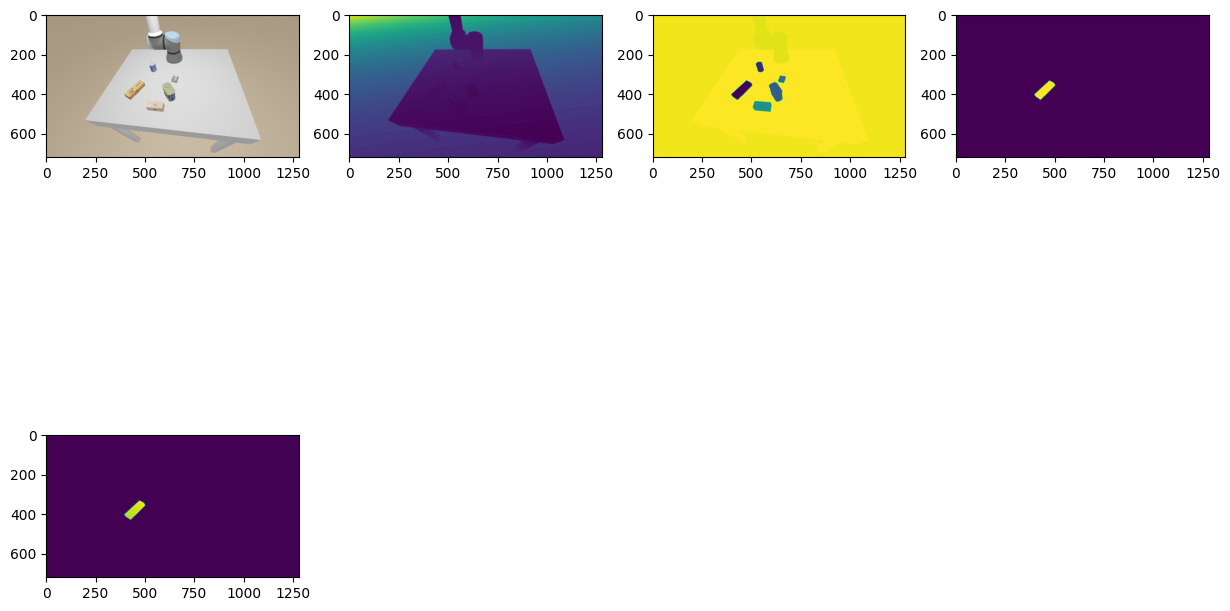

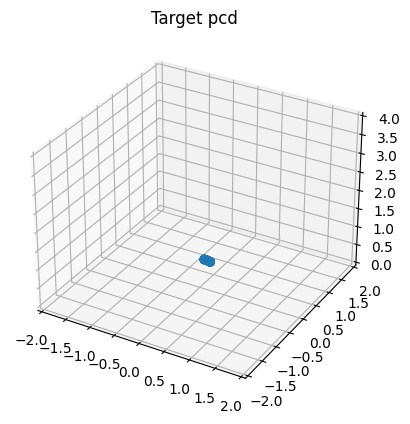

In [9]:
import numpy as np


def get_point_cloud(depth, intrinsic):
  z = depth
  v, u = np.indices(z.shape)
  uv1 = np.stack([u + 0.5, v + 0.5, np.ones_like(z)], axis=-1)
  points_viewer = uv1 @ np.linalg.inv(intrinsic).T * z[..., None]  # [H, W, 3]
  return points_viewer

def get_object_point_cloud(test_image_label, object_id, test_depth, intrinsic):
  # print(np.where(test_image_label==object_id))
  # print(test_image_label[327][654])
  test_image_label[np.where(test_image_label==object_id)] = 255
  # print(test_image_label[327][654])
  # print(np.where(test_image_label==255))
  test_image_label[np.where(test_image_label!=255)] = 0
  test_image_label[np.where(test_image_label==255)] = 1
  test_object_depth = test_depth * test_image_label
  test_pcd_target = get_point_cloud(test_object_depth, intrinsic)
  # (H, W, dim) = test_pcd_target.shape
  # filter out target object point cloud
  # print(test_pcd_target.shape)
  # print(test_pcd_target)
  # print((test_pcd_target[:,0]!=0)|(test_pcd_target[:,1]!=0)|(test_pcd_target[:,2]!=0))
  test_pcd_target = test_pcd_target.reshape(-1, test_pcd_target.shape[-1]) # reshape to (H*W, 3)
  test_pcd_target = test_pcd_target[(test_pcd_target[:,0]!=0)|(test_pcd_target[:,1]!=0)|(test_pcd_target[:,2]!=0)]
  return test_pcd_target


rgb_files, depth_files, label_files, meta_files, prefix_ids = get_train_split_files('val')
# rgb_files: RGB color maps
# depth_files: Depth map
# label_files: Segmentation mask
# meta_files: Pose. Extrinsics. Intrinsics
rgb = np.array(Image.open(rgb_files[0])) / 255   # convert 0-255 to 0-1
depth = np.array(Image.open(depth_files[0])) / 1000   # convert from mm to m
label = np.array(Image.open(label_files[0]))
meta = load_pickle(meta_files[0])
ids, names, intrinsic, scales = meta["object_ids"], meta["object_names"], meta["intrinsic"], meta["scales"]
print(ids)
print(names)
print(label_files[0])
print(scales)
plt.figure(figsize=(15, 10))
plt.subplot(2, 4, 1)
plt.imshow(rgb)
plt.subplot(2, 4, 2)
plt.imshow(depth)
plt.subplot(2, 4, 3)
plt.imshow(label)  # draw colorful segmentation
print(meta.keys())
# print(rgb.reshape(-1, rgb.shape[-1]).shape)
a=rgb.reshape(-1, rgb.shape[-1])
# meta['object_names']
# label[np.where(label==35)] = 80
object_id = 35
label[np.where(label==object_id)] = 255
# print(label[327][654])
# print(np.where(label==255))
label[np.where(label!=255)] = 0
label[np.where(label==255)] = 1
plt.subplot(2, 4, 4)
plt.imshow(label)
# print(label[label!=0])
depth = depth * label
plt.subplot(2, 4, 5)
plt.imshow(depth)
print(depth[depth!=0])
# depth *= 1000
pcd = get_point_cloud(depth, intrinsic)
print(pcd.shape)
pcd = pcd.reshape(-1, pcd.shape[-1]) # reshape to (H*W, 3)
pcd = pcd[(pcd[:,0]!=0)|(pcd[:,1]!=0)|(pcd[:,2]!=0)]
print(pcd.shape)
# show_points(pcd, "Target 1 pcd")
pcd = pcd * scales[object_id]
print(pcd.shape)
show_points(pcd, "Target pcd")



In [10]:
from matplotlib.cm import get_cmap
NUM_OBJECTS = 79
cmap = get_cmap('rainbow', NUM_OBJECTS)
COLOR_PALETTE = np.array([cmap(i)[:3] for i in range(NUM_OBJECTS + 3)])
COLOR_PALETTE = np.array(COLOR_PALETTE * 255, dtype=np.uint8)
COLOR_PALETTE[-3] = [119, 135, 150]
COLOR_PALETTE[-2] = [176, 194, 216]
COLOR_PALETTE[-1] = [255, 255, 225]

<ipython-input-10-80c26a906e79>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('rainbow', NUM_OBJECTS)


# Testing data loading

In [11]:
test_split_dir = "./testing_data_pose_filtered/testing_data"
testing_data_root = "./testing_data_pose_filtered/testing_data"
testing_data_dir = "./testing_data_pose_filtered/testing_data/v2.2"

def get_test_split_files(split_name):
    with open(os.path.join(test_split_dir, f"{split_name}.txt"), 'r') as f:
        # for line in f:
        #   print(line)
        #   if line.strip():
        #     print(testing_data_dir)
        #     print(line.strip())
        prefixIds = [line.strip() for line in f if line.strip()]
        prefix = [os.path.join(testing_data_dir, line) for line in prefixIds]
        # print(prefixIds)
        # print(prefix)
        rgb = [p + "_color_kinect.png" for p in prefix]
        depth = [p + "_depth_kinect.png" for p in prefix]
        label = [p + "_label_kinect.png" for p in prefix]
        meta = [p + "_meta.pkl" for p in prefix]
    return rgb, depth, label, meta, prefixIds

In [12]:
test_rgb_files, test_depth_files, test_label_files, test_meta_files, test_prefix_ids = get_test_split_files('test')
test_size = len(test_rgb_files)
test_meta = load_pickle(test_meta_files[0])
# test_meta = load_pickle(meta_files[0])
print(test_meta.keys())
# print(test_meta["poses_world"])
print(test_size)
print(test_prefix_ids)
# print(test_meta_files)

dict_keys(['extents', 'scales', 'object_ids', 'object_names', 'extrinsic', 'intrinsic'])
200
['1-1-1', '1-2-1', '1-3-1', '1-4-1', '1-5-1', '1-6-1', '1-7-1', '1-8-1', '1-9-1', '1-10-1', '1-11-1', '1-12-1', '1-13-1', '1-14-1', '1-15-1', '1-16-1', '1-17-1', '1-18-1', '1-19-1', '1-20-1', '1-21-1', '1-22-1', '1-23-1', '1-24-1', '1-25-1', '1-26-1', '1-27-1', '1-28-1', '1-29-1', '1-30-1', '1-31-1', '1-32-1', '1-33-1', '1-34-1', '1-35-1', '1-36-1', '1-37-1', '1-38-1', '1-39-1', '1-40-1', '1-41-1', '1-42-1', '1-43-1', '1-44-1', '1-45-1', '1-46-1', '1-47-1', '1-48-1', '1-49-1', '1-50-1', '1-51-1', '1-52-1', '1-53-1', '1-54-1', '1-55-1', '1-56-1', '1-57-1', '1-58-1', '1-59-1', '1-60-1', '1-61-1', '1-62-1', '1-63-1', '1-64-1', '1-65-1', '1-66-1', '1-67-1', '1-68-1', '1-69-1', '1-70-1', '1-71-1', '1-72-1', '1-73-1', '1-74-1', '1-75-1', '1-76-1', '1-77-1', '1-78-1', '1-79-1', '1-80-1', '1-81-1', '1-82-1', '1-83-1', '1-84-1', '1-85-1', '1-86-1', '1-87-1', '1-88-1', '1-89-1', '1-90-1', '1-91-1', '1-92

# ICP implementation

In [13]:
"""ICP implementation"""
import open3d as o3d
from tqdm import tqdm
import numpy as np
from sklearn.neighbors import NearestNeighbors
# # def compute_corr(source_pcd, target_pcd):
# #     """
# #     Compute src tg pcd correspondances
# #     """
# #     return corr


def oneNN(source_pcd, target_pcd):
    '''
    Map source_pcd to nearest neighbour in target_pcd
    Input:
        source_pcd: Nx3 array of points
        target_pcd: Nx3 array of points
    Output:
        dists: Euclidean distances of the nearest neighbor
        inds: target_pcd indices of the nearest neighbor
    '''
    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(target_pcd)
    dists, inds = neigh.kneighbors(source_pcd, return_distance=True)
    return dists.ravel(), inds.ravel()



def getRT(source_pcd, target_pcd):
    """
    Get R, t, given source pcd and aligned target pcd
    """
    # Get R, t (by Umeyama's minimization of distance)
    N = source_pcd.shape[0]
    qbar = np.mean(target_pcd, axis=0)
    pbar = np.mean(source_pcd, axis=0)
    # print(qbar, pbar)
    # Q, P = (target_pcd).T , (source_pcd).T
    # M = N * np.outer(pbar, qbar)
    # M = (target_pcd-qbar).T @ (source_pcd-pbar)
    M = (target_pcd-qbar).T @ (source_pcd-pbar)
    U, D, VT = np.linalg.svd(M)

    R = U @ VT
    if (np.linalg.det(R)<0):
        VT[-1,:] *= -1
        R = U @ VT

    t = qbar - (R @ pbar)
    return R, t

def icp(source_pcd, target_pcd, steps=50):
    """Iterative closest point.

    Args:
        source_pcd (np.ndarray): [N1, 3]
        target_pcd (np.ndarray): [N2, 3]

    Returns:
        np.ndarray: [4, 4] rigid transformation to align source to target.
    """
    T = np.eye(4)
    R, t = np.eye(3), np.zeros(3)
    N = source_pcd.shape[0]
    source_pcd_cp = source_pcd.copy()

    # Implement your own algorithm here.
    nsteps = steps
    for i in tqdm(range(nsteps)):
        # Update correspondance (by re-aligning target)
        distances, indices = oneNN(source_pcd, target_pcd)
        # if (i==0):
        # print("min distance: {}".format(np.min(distances)))
        # Umayama's algo for getting R, t
        R, t = getRT(source_pcd, target_pcd[indices, :])
        source_pcd = source_pcd @ R.T + t

    R, t = getRT(source_pcd_cp, source_pcd)
    T[:3, :3], T[:3, -1] = R, t
    # print("Final T:")
    # print(T)
    # print(T.tolist())
    return T

# def get_o3d_icp(source_pcd, target_pcd):
#   # T = icp(source_pcd, target_pcd, 150)
#   source_pcd_o3d, target_pcd_o3d = o3d.geometry.PointCloud(), o3d.geometry.PointCloud()
#   # print(source_pcd)
#   source_pcd_o3d.points = o3d.utility.Vector3dVector(source_pcd)
#   # source_pcd_o3d.estimate_normals(o3d.geometry.KDTreeSearchParamKNN(knn=50))
#   target_pcd_o3d.points = o3d.utility.Vector3dVector(target_pcd)
#   # print(source_pcd_o3d)
#   # print(target_pcd_o3d)
#   # target_pcd_o3d.estimate_normals(o3d.geometry.KDTreeSearchParamKNN(knn=50))
#   init = np.eye(4)
#   # init[0,0] = 2
#   T = o3d.pipelines.registration.registration_icp( \
#         source_pcd_o3d, target_pcd_o3d, 5, init, \
#         o3d.pipelines.registration.TransformationEstimationPointToPoint(), \
#         o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=2000))
#   # T = icp(source_pcd, target_pcd)
#   T = T.transformation
#   return T


def get_o3d_icp(source_pcd, target_pcd):
  # T = icp(source_pcd, target_pcd, 150)
  source_pcd_o3d, target_pcd_o3d = o3d.geometry.PointCloud(), o3d.geometry.PointCloud()
  # print(source_pcd)
  source_pcd_o3d.points = o3d.utility.Vector3dVector(source_pcd)
  # source_pcd_o3d.estimate_normals(o3d.geometry.KDTreeSearchParamKNN(knn=50))
  target_pcd_o3d.points = o3d.utility.Vector3dVector(target_pcd)
  # print(source_pcd_o3d)
  # print(target_pcd_o3d)
  # target_pcd_o3d.estimate_normals(o3d.geometry.KDTreeSearchParamKNN(knn=50))
  init = np.eye(4)
  # init[0,0] = 2
  T = o3d.pipelines.registration.registration_icp( \
        source_pcd_o3d, target_pcd_o3d, 5, init, \
        o3d.pipelines.registration.TransformationEstimationPointToPoint(), \
        o3d.pipelines.registration.ICPConvergenceCriteria(relative_fitness=0.00000001, \
                                 relative_rmse=0.00000001, \
                                 max_iteration=500))
  # T = icp(source_pcd, target_pcd)
  # print(T.inlier_rmse)
  # print(T.fitness)
  # print(T.correspondence_set)
  T = T.transformation
  return T


# Sample canonical-space point cloud

---



In [14]:
!pip install trimesh
!pip install pycollada

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 688.2/688.2 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.6/107.6 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pycollada: filename=pycollada-0.7.2-py3-none-any.whl size=127016 sha256=6566d6717365ec5535508ae9acb0ed490fc9c188f429d135db89862bc3480a5f
  Stored in directory: /root/.cache/pip/wheels/d5/ba/33/1e99a7e7defd1d77f0210e7a39ff58de2a2d8d4c22466bb2da
Successfully built pycollada


In [15]:
object_models_file = os.path.join(training_data_root, "objects_v1.csv")


In [16]:
# Load the canonical-space object point clouds
import trimesh
import collada
import os
import pandas as pd

def fps_downsample(points, number_of_points_to_sample):
  selected_points = np.zeros((number_of_points_to_sample, 3))
  dist = np.ones(points.shape[0]) * np.inf # distance to the selected set
  for i in tqdm(range(number_of_points_to_sample)):
      # pick the point with max dist
      idx = np.argmax(dist)
      selected_points[i] = points[idx]
      dist_ = ((points - selected_points[i]) ** 2).sum(-1)
      dist = np.minimum(dist, dist_)
  return selected_points

object_models_info = pd.read_csv(object_models_file)
object_models_name = object_models_info["object"].to_list()
object_models_location = object_models_info["location"].to_list()
object_models_num = len(object_models_name)


object_models = {}
for object_name, object_mesh_dir in zip(object_models_name, object_models_location):
  object_mesh_path = os.path.join(object_mesh_dir, "visual_meshes", "visual.dae")
  # object_mesh = trimesh.exchange.dae.load_collada(object_mesh_path)
  # mesh_name = object_mesh['graph'][0]['geometry']
  # object_models[object_name] = object_mesh['geometry'][mesh_name]['vertices']
  object_mesh = trimesh.load(object_mesh_path, force='mesh')
  object_models[object_name] = object_mesh.vertices
  # print(object_mesh)

# object_models with key=objectName, value=objectPointCloud
# print(object_models_info)
print(object_models["jenga"])
print(len(object_models["jenga"]))
# print(np.unique(object_models["jenga"]))
# print(len(object_models))







[[-0.07499998 -0.02499997  0.01499998]
 [ 0.07499998 -0.02499997  0.01499998]
 [ 0.07499998  0.02499997  0.01499998]
 [-0.07499998  0.02499997  0.01499998]
 [ 0.07499998  0.02499997 -0.01499998]
 [ 0.07499998 -0.02499997 -0.01499998]
 [-0.07499998 -0.02499997 -0.01499998]
 [-0.07499998  0.02499997 -0.01499998]
 [-0.07499998  0.02499997  0.01499998]
 [-0.07499998  0.02499997 -0.01499998]
 [-0.07499998 -0.02499997 -0.01499998]
 [-0.07499998 -0.02499997  0.01499998]
 [ 0.07499998 -0.02499997 -0.01499998]
 [ 0.07499998  0.02499997 -0.01499998]
 [ 0.07499998  0.02499997  0.01499998]
 [ 0.07499998 -0.02499997  0.01499998]
 [ 0.07499998 -0.02499997  0.01499998]
 [-0.07499998 -0.02499997  0.01499998]
 [-0.07499998 -0.02499997 -0.01499998]
 [ 0.07499998 -0.02499997 -0.01499998]
 [-0.07499998  0.02499997 -0.01499998]
 [-0.07499998  0.02499997  0.01499998]
 [ 0.07499998  0.02499997  0.01499998]
 [ 0.07499998  0.02499997 -0.01499998]]
24


# ICP-based Pose Estimation on test data

In [17]:
import numpy as np
import json
# # Helper function for the reconstruction of the target point cloud
# rgb = np.array(Image.open(rgb_files[0])) / 255   # convert 0-255 to 0-1
# depth = np.array(Image.open(depth_files[0])) / 1000   # convert from mm to m
# label = np.array(Image.open(label_files[0]))
# meta = load_pickle(meta_files[0])
# intrinsic = meta['intrinsic']
# z = depth
# v, u = np.indices(z.shape)
# uv1 = np.stack([u + 0.5, v + 0.5, np.ones_like(z)], axis=-1)
# points_viewer = uv1 @ np.linalg.inv(intrinsic).T * z[..., None]  # [H, W, 3]
# # print(points_viewer.shape)
# # print(points_viewer.shape[0]*points_viewer.shape[1])
# # print(points_viewer)

def dump_json(sample, path):
  with open(path, 'w') as fp:
    json.dump(sample, fp)
  return 0

def load_json(path):
  f = open(path)
  data = json.load(f)
  return data

def get_point_cloud(depth, intrinsic):
  z = depth
  v, u = np.indices(z.shape)
  uv1 = np.stack([u + 0.5, v + 0.5, np.ones_like(z)], axis=-1)
  points_viewer = uv1 @ np.linalg.inv(intrinsic).T * z[..., None]  # [H, W, 3]
  return points_viewer

def get_object_point_cloud(test_image_label, object_id, test_depth, intrinsic):
  # print(np.where(test_image_label==object_id))
  # print(test_image_label[327][654])
  test_image_label[np.where(test_image_label==object_id)] = 255
  # print(test_image_label[327][654])
  # print(np.where(test_image_label==255))
  test_image_label[np.where(test_image_label!=255)] = 0
  test_image_label[np.where(test_image_label==255)] = 1
  test_object_depth = test_depth * test_image_label
  test_pcd_target = get_point_cloud(test_object_depth, intrinsic)
  # (H, W, dim) = test_pcd_target.shape
  # filter out target object point cloud
  # print(test_pcd_target.shape)
  # print(test_pcd_target)
  # print((test_pcd_target[:,0]!=0)|(test_pcd_target[:,1]!=0)|(test_pcd_target[:,2]!=0))
  test_pcd_target = test_pcd_target.reshape(-1, test_pcd_target.shape[-1]) # reshape to (H*W, 3)
  test_pcd_target = test_pcd_target[(test_pcd_target[:,0]!=0)|(test_pcd_target[:,1]!=0)|(test_pcd_target[:,2]!=0)]
  return test_pcd_target


def get_meta(meta_path):
  return load_pickle(meta_path)

def get_depth(depth_path):
  return (np.array(Image.open(depth_path))/1000)

def get_label(label_path):
  return np.array(Image.open(label_path))



In [18]:
# Test ICP estimation on the test set
!mkdir test_outputs
!mkdir test_outputs_2
!mkdir test_outputs_3
import numpy as np
from tqdm import tqdm

# Output resulting dictionary
timee = 3
dataset_type = "test"
output_dir = "./{}_outputs_{}".format(dataset_type, timee)


# For each object at each testing data: Get scene object's point cloud (as target pcd)
result_dict = {}

print(test_depth_files)
print(test_meta_files)
print(test_label_files)
print(test_prefix_ids)

# for test_depth_path, test_meta_path, test_label_path, test_prefix_id in tqdm(zip(test_depth_files, test_meta_files, test_label_files, test_prefix_ids)):
for i in (range(test_size)):
  test_depth_path, test_meta_path, test_label_path, test_prefix_id = test_depth_files[i], test_meta_files[i], test_label_files[i], test_prefix_ids[i]
  print("Test data id {}".format(test_prefix_id))
  test_meta, test_depth, test_seg_label = get_meta(test_meta_path), get_depth(test_depth_path), get_label(test_label_path)   # convert from mm to m
  intrinsic = test_meta["intrinsic"]
  extrinsic = test_meta["extrinsic"]
  inv_extrinsic = np.linalg.inv(extrinsic)
  scales = test_meta["scales"]
  result_dict[test_prefix_id] = {}
  result_dict[test_prefix_id]["poses_world"] = [None] * object_models_num
  for object_id, object_name in zip(test_meta["object_ids"], test_meta["object_names"]):
    print("Object id {}, name {}".format(object_id, object_name))
    if (np.sum(test_seg_label==object_id) == 0):
      print("Object not found at scene.")
      continue
    test_image_label = test_seg_label.copy()
    # print(object_id, type(object_id))
    # print(test_image_label)

    # mask the object's depth map to get test_object_depth
    test_pcd_target = get_object_point_cloud(test_image_label, object_id, test_depth, intrinsic)

    # Fetch source point cloud from model dictionary
    test_pcd_source = object_models[object_name]
    test_pcd_source *= scales[object_id] # scale the model pcd using factors
    # print(test_pcd_source.shape)
    # print(test_pcd_target.shape)

    # ICP to get posture
    # test_pcd_source = fps_downsample(test_pcd_source, len(test_pcd_target))
    T = get_o3d_icp(test_pcd_source, test_pcd_target)
    # T = icp(test_pcd_source, test_pcd_target)
    T_world = inv_extrinsic @ T # Transform to world coordinate
    # print(test_pcd_source)
    # print(test_pcd_target)
    # print(T_world)
    # T = o3d.pipelines.registration.registration_icp( \
    #   test_pcd_source, test_pcd_target, 0.02, np.eye(4), \
    #   o3d.pipelines.registration.TransformationEstimationPointToPlane())

    # update resulting dictionary with object id and pose list
    result_dict[test_prefix_id]["poses_world"][object_id] = T_world.tolist()
  output_name = "result_till_{}_index_{}.json".format(test_prefix_id, i)
  dump_json(result_dict, os.path.join(output_dir, output_name))

print("Test result:")
print(result_dict)
print(len(result_dict))



output_name = "result.json"
dump_json(result_dict, os.path.join(output_dir, output_name))
!cp /content/test_outputs_3/result.json /content/drive/MyDrive/outputs
!cp -r /content/test_outputs_3 /content/drive/MyDrive/


['./testing_data_pose_filtered/testing_data/v2.2/1-1-1_depth_kinect.png', './testing_data_pose_filtered/testing_data/v2.2/1-2-1_depth_kinect.png', './testing_data_pose_filtered/testing_data/v2.2/1-3-1_depth_kinect.png', './testing_data_pose_filtered/testing_data/v2.2/1-4-1_depth_kinect.png', './testing_data_pose_filtered/testing_data/v2.2/1-5-1_depth_kinect.png', './testing_data_pose_filtered/testing_data/v2.2/1-6-1_depth_kinect.png', './testing_data_pose_filtered/testing_data/v2.2/1-7-1_depth_kinect.png', './testing_data_pose_filtered/testing_data/v2.2/1-8-1_depth_kinect.png', './testing_data_pose_filtered/testing_data/v2.2/1-9-1_depth_kinect.png', './testing_data_pose_filtered/testing_data/v2.2/1-10-1_depth_kinect.png', './testing_data_pose_filtered/testing_data/v2.2/1-11-1_depth_kinect.png', './testing_data_pose_filtered/testing_data/v2.2/1-12-1_depth_kinect.png', './testing_data_pose_filtered/testing_data/v2.2/1-13-1_depth_kinect.png', './testing_data_pose_filtered/testing_data/v2.

In [19]:
!cp -r test_outputs_2 /content/drive/MyDrive/

# ICP-based Pose Estimation on test data (continual estimation)

In [20]:
!cp -r /content/drive/MyDrive/test_outputs_2 ./

In [21]:
# Start ICP estimation for all test data
!mkdir test_outputs
import numpy as np
from tqdm import tqdm
import os

# Flag for continuing from previous steps
ctu = True
ctu_variant, ctu_index = 0, 0
if ctu:
  ctu_variant, ctu_index = "2-55-1", 154

# Output resulting dictionary
dataset_type = "test"
output_dir = "./{}_outputs_2".format(dataset_type)


# For each object at each testing data: Get scene object's point cloud (as target pcd)
result_dict = {}
if ctu:
  json_path = os.path.join(output_dir, "result_till_{}_index_{}.json".format(ctu_variant, ctu_index))
  result_dict = load_json(json_path)
print(test_depth_files)
print(test_meta_files)
print(test_label_files)
print(test_prefix_ids)

# for test_depth_path, test_meta_path, test_label_path, test_prefix_id in tqdm(zip(test_depth_files, test_meta_files, test_label_files, test_prefix_ids)):
for i in range(ctu_index, test_size):
  test_depth_path, test_meta_path, test_label_path, test_prefix_id = test_depth_files[i], test_meta_files[i], test_label_files[i], test_prefix_ids[i]
  print("Test data id {}".format(test_prefix_id))
  test_meta, test_depth, test_seg_label = get_meta(test_meta_path), get_depth(test_depth_path), get_label(test_label_path)   # convert from mm to m
  intrinsic = test_meta["intrinsic"]
  extrinsic = test_meta["extrinsic"]
  inv_extrinsic = np.linalg.inv(extrinsic)
  scales = test_meta["scales"]
  result_dict[test_prefix_id] = {}
  result_dict[test_prefix_id]["poses_world"] = [None] * object_models_num
  for object_id, object_name in zip(test_meta["object_ids"], test_meta["object_names"]):
    # print(test_meta["object_ids"], test_meta["object_names"])
    print("Object id {}, name {}".format(object_id, object_name))
    # if (object_id != 56):
      # continue
    # mask the object's depth map to get test_object_depth
    # print(object_id, type(object_id))
    # print(np.sum(test_seg_label==object_id))
    if (np.sum(test_seg_label==object_id) == 0):
      print("Object not found at scene.")
      continue
    test_image_label = test_seg_label.copy()

    # mask the object's depth map to get test_object_depth
    # print(test_image_label[test_image_label==30])
    # print(test_image_label[test_image_label==51])
    test_pcd_target = get_object_point_cloud(test_image_label, object_id, test_depth, intrinsic)

    # Fetch source point cloud from model dictionary
    test_pcd_source = object_models[object_name]
    test_pcd_source *= scales[object_id] # scale the model pcd using factors
    # print(test_pcd_source.shape)
    # print(test_pcd_target.shape)

    # ICP to get posture
    T = icp(test_pcd_source, test_pcd_target, 100)
    T_world = inv_extrinsic @ T # Transform to world coordinate

    # update resulting dictionary with object id and pose list
    result_dict[test_prefix_id]["poses_world"][object_id] = T_world.tolist()
  output_name = "result_till_{}_index_{}.json".format(test_prefix_id, i)
  dump_json(result_dict, os.path.join(output_dir, output_name))

print("Test result:")
print(result_dict)
print(len(result_dict))



# Output resulting dictionary
output_name = "result.json"
dump_json(result_dict, os.path.join(output_dir, output_name))






mkdir: cannot create directory ‘test_outputs’: File exists
['./testing_data_pose_filtered/testing_data/v2.2/1-1-1_depth_kinect.png', './testing_data_pose_filtered/testing_data/v2.2/1-2-1_depth_kinect.png', './testing_data_pose_filtered/testing_data/v2.2/1-3-1_depth_kinect.png', './testing_data_pose_filtered/testing_data/v2.2/1-4-1_depth_kinect.png', './testing_data_pose_filtered/testing_data/v2.2/1-5-1_depth_kinect.png', './testing_data_pose_filtered/testing_data/v2.2/1-6-1_depth_kinect.png', './testing_data_pose_filtered/testing_data/v2.2/1-7-1_depth_kinect.png', './testing_data_pose_filtered/testing_data/v2.2/1-8-1_depth_kinect.png', './testing_data_pose_filtered/testing_data/v2.2/1-9-1_depth_kinect.png', './testing_data_pose_filtered/testing_data/v2.2/1-10-1_depth_kinect.png', './testing_data_pose_filtered/testing_data/v2.2/1-11-1_depth_kinect.png', './testing_data_pose_filtered/testing_data/v2.2/1-12-1_depth_kinect.png', './testing_data_pose_filtered/testing_data/v2.2/1-13-1_depth_

100%|██████████| 100/100 [00:04<00:00, 24.11it/s]


Object id 14, name cracker_box


100%|██████████| 100/100 [00:01<00:00, 68.59it/s]


Object id 26, name foam_brick


100%|██████████| 100/100 [00:04<00:00, 20.72it/s]


Object id 29, name g_lego_duplo


100%|██████████| 100/100 [00:03<00:00, 29.79it/s]


Object id 35, name jenga


100%|██████████| 100/100 [00:00<00:00, 352.24it/s]


Object id 42, name mustard_bottle


100%|██████████| 100/100 [00:04<00:00, 24.00it/s]


Object id 52, name rubiks_cube


100%|██████████| 100/100 [00:03<00:00, 31.92it/s]


Object id 55, name sugar_box


100%|██████████| 100/100 [00:01<00:00, 68.02it/s]


Object id 56, name tomato_soup_can


100%|██████████| 100/100 [00:05<00:00, 17.15it/s]


Object id 57, name tuna_fish_can


100%|██████████| 100/100 [00:01<00:00, 57.03it/s]


Test data id 2-56-1
Object id 8, name bleach_cleanser


100%|██████████| 100/100 [00:04<00:00, 21.23it/s]


Object id 14, name cracker_box


100%|██████████| 100/100 [00:01<00:00, 71.47it/s]


Object id 26, name foam_brick


100%|██████████| 100/100 [00:03<00:00, 32.68it/s]


Object id 29, name g_lego_duplo


100%|██████████| 100/100 [00:02<00:00, 43.50it/s]


Object id 35, name jenga


100%|██████████| 100/100 [00:00<00:00, 195.36it/s]


Object id 42, name mustard_bottle


100%|██████████| 100/100 [00:07<00:00, 13.08it/s]


Object id 52, name rubiks_cube


100%|██████████| 100/100 [00:03<00:00, 33.09it/s]


Object id 55, name sugar_box


100%|██████████| 100/100 [00:01<00:00, 65.27it/s]


Object id 56, name tomato_soup_can


100%|██████████| 100/100 [00:03<00:00, 26.77it/s]


Object id 57, name tuna_fish_can


100%|██████████| 100/100 [00:01<00:00, 80.34it/s]


Test data id 2-57-1
Object id 8, name bleach_cleanser


100%|██████████| 100/100 [00:08<00:00, 11.98it/s]


Object id 14, name cracker_box


100%|██████████| 100/100 [00:02<00:00, 44.86it/s]


Object id 26, name foam_brick


100%|██████████| 100/100 [00:03<00:00, 32.41it/s]


Object id 29, name g_lego_duplo


100%|██████████| 100/100 [00:02<00:00, 47.68it/s]


Object id 35, name jenga


100%|██████████| 100/100 [00:00<00:00, 276.26it/s]


Object id 42, name mustard_bottle


100%|██████████| 100/100 [00:05<00:00, 18.64it/s]


Object id 52, name rubiks_cube


100%|██████████| 100/100 [00:06<00:00, 16.32it/s]


Object id 55, name sugar_box


100%|██████████| 100/100 [00:01<00:00, 57.78it/s]


Object id 56, name tomato_soup_can


100%|██████████| 100/100 [00:03<00:00, 26.44it/s]


Object id 57, name tuna_fish_can


100%|██████████| 100/100 [00:01<00:00, 91.93it/s]


Test data id 2-58-1
Object id 8, name bleach_cleanser


100%|██████████| 100/100 [00:04<00:00, 20.58it/s]


Object id 14, name cracker_box


100%|██████████| 100/100 [00:02<00:00, 49.46it/s]


Object id 26, name foam_brick


100%|██████████| 100/100 [00:02<00:00, 46.66it/s]


Object id 29, name g_lego_duplo


100%|██████████| 100/100 [00:03<00:00, 28.04it/s]


Object id 35, name jenga


100%|██████████| 100/100 [00:00<00:00, 391.90it/s]


Object id 42, name mustard_bottle


100%|██████████| 100/100 [00:03<00:00, 31.75it/s]


Object id 52, name rubiks_cube


100%|██████████| 100/100 [00:03<00:00, 29.56it/s]


Object id 55, name sugar_box


100%|██████████| 100/100 [00:01<00:00, 70.41it/s]


Object id 56, name tomato_soup_can


100%|██████████| 100/100 [00:04<00:00, 24.95it/s]


Object id 57, name tuna_fish_can


100%|██████████| 100/100 [00:01<00:00, 56.21it/s]


Test data id 2-59-1
Object id 8, name bleach_cleanser


100%|██████████| 100/100 [00:06<00:00, 14.71it/s]


Object id 14, name cracker_box


100%|██████████| 100/100 [00:01<00:00, 71.55it/s]


Object id 26, name foam_brick


100%|██████████| 100/100 [00:02<00:00, 34.51it/s]


Object id 29, name g_lego_duplo


100%|██████████| 100/100 [00:01<00:00, 52.00it/s]


Object id 35, name jenga


100%|██████████| 100/100 [00:00<00:00, 426.55it/s]


Object id 42, name mustard_bottle


100%|██████████| 100/100 [00:06<00:00, 15.92it/s]


Object id 52, name rubiks_cube


100%|██████████| 100/100 [00:05<00:00, 18.67it/s]


Object id 55, name sugar_box


100%|██████████| 100/100 [00:01<00:00, 86.09it/s]


Object id 56, name tomato_soup_can


100%|██████████| 100/100 [00:03<00:00, 27.04it/s]


Object id 57, name tuna_fish_can


100%|██████████| 100/100 [00:01<00:00, 82.02it/s]


Test data id 2-60-1
Object id 8, name bleach_cleanser


100%|██████████| 100/100 [00:05<00:00, 18.22it/s]


Object id 14, name cracker_box


100%|██████████| 100/100 [00:01<00:00, 50.48it/s]


Object id 26, name foam_brick


100%|██████████| 100/100 [00:04<00:00, 23.51it/s]


Object id 29, name g_lego_duplo


100%|██████████| 100/100 [00:02<00:00, 44.35it/s]


Object id 35, name jenga


100%|██████████| 100/100 [00:00<00:00, 438.60it/s]


Object id 42, name mustard_bottle


100%|██████████| 100/100 [00:04<00:00, 23.56it/s]


Object id 52, name rubiks_cube


100%|██████████| 100/100 [00:03<00:00, 26.03it/s]


Object id 55, name sugar_box


100%|██████████| 100/100 [00:02<00:00, 45.40it/s]


Object id 56, name tomato_soup_can


100%|██████████| 100/100 [00:05<00:00, 18.71it/s]


Object id 57, name tuna_fish_can


100%|██████████| 100/100 [00:01<00:00, 66.58it/s]


Test data id 2-61-1
Object id 1, name a_lego_duplo


100%|██████████| 100/100 [00:02<00:00, 46.29it/s]


Object id 8, name bleach_cleanser


100%|██████████| 100/100 [00:04<00:00, 20.61it/s]


Object id 21, name e_toy_airplane


100%|██████████| 100/100 [00:02<00:00, 39.93it/s]


Object id 30, name gelatin_box


100%|██████████| 100/100 [00:04<00:00, 21.32it/s]


Object id 35, name jenga


100%|██████████| 100/100 [00:00<00:00, 198.01it/s]


Object id 42, name mustard_bottle


100%|██████████| 100/100 [00:04<00:00, 24.16it/s]


Object id 48, name potted_meat_can


100%|██████████| 100/100 [00:06<00:00, 15.09it/s]


Object id 55, name sugar_box


100%|██████████| 100/100 [00:02<00:00, 36.11it/s]


Object id 57, name tuna_fish_can


100%|██████████| 100/100 [00:01<00:00, 53.25it/s]


Object id 58, name wood_block


100%|██████████| 100/100 [00:02<00:00, 42.37it/s]


Test data id 2-62-1
Object id 1, name a_lego_duplo


100%|██████████| 100/100 [00:03<00:00, 27.73it/s]


Object id 8, name bleach_cleanser


100%|██████████| 100/100 [00:05<00:00, 19.49it/s]


Object id 21, name e_toy_airplane


100%|██████████| 100/100 [00:01<00:00, 55.19it/s]


Object id 30, name gelatin_box


100%|██████████| 100/100 [00:03<00:00, 26.61it/s]


Object id 35, name jenga


100%|██████████| 100/100 [00:00<00:00, 264.16it/s]


Object id 42, name mustard_bottle


100%|██████████| 100/100 [00:05<00:00, 18.08it/s]


Object id 48, name potted_meat_can


100%|██████████| 100/100 [00:04<00:00, 23.38it/s]


Object id 55, name sugar_box


100%|██████████| 100/100 [00:01<00:00, 61.82it/s]


Object id 57, name tuna_fish_can


100%|██████████| 100/100 [00:01<00:00, 81.39it/s]


Object id 58, name wood_block


100%|██████████| 100/100 [00:01<00:00, 56.22it/s]


Test data id 2-63-1
Object id 1, name a_lego_duplo


100%|██████████| 100/100 [00:02<00:00, 40.23it/s]


Object id 8, name bleach_cleanser


100%|██████████| 100/100 [00:06<00:00, 14.81it/s]


Object id 21, name e_toy_airplane


100%|██████████| 100/100 [00:02<00:00, 38.48it/s]


Object id 30, name gelatin_box


100%|██████████| 100/100 [00:03<00:00, 33.01it/s]


Object id 35, name jenga


100%|██████████| 100/100 [00:00<00:00, 233.31it/s]


Object id 42, name mustard_bottle


100%|██████████| 100/100 [00:03<00:00, 28.88it/s]


Object id 48, name potted_meat_can


100%|██████████| 100/100 [00:04<00:00, 20.17it/s]


Object id 55, name sugar_box


100%|██████████| 100/100 [00:02<00:00, 44.57it/s]


Object id 57, name tuna_fish_can
Object not found at scene.
Object id 58, name wood_block


100%|██████████| 100/100 [00:02<00:00, 47.60it/s]


Test data id 2-64-1
Object id 1, name a_lego_duplo


100%|██████████| 100/100 [00:03<00:00, 32.83it/s]


Object id 8, name bleach_cleanser


100%|██████████| 100/100 [00:05<00:00, 17.41it/s]


Object id 21, name e_toy_airplane


100%|██████████| 100/100 [00:01<00:00, 54.97it/s]


Object id 30, name gelatin_box


100%|██████████| 100/100 [00:03<00:00, 33.27it/s]


Object id 35, name jenga


100%|██████████| 100/100 [00:00<00:00, 288.68it/s]


Object id 42, name mustard_bottle


100%|██████████| 100/100 [00:06<00:00, 15.85it/s]


Object id 48, name potted_meat_can


100%|██████████| 100/100 [00:04<00:00, 21.07it/s]


Object id 55, name sugar_box


100%|██████████| 100/100 [00:01<00:00, 63.68it/s]


Object id 57, name tuna_fish_can


100%|██████████| 100/100 [00:01<00:00, 80.02it/s]


Object id 58, name wood_block


100%|██████████| 100/100 [00:01<00:00, 54.76it/s]


Test data id 2-65-1
Object id 1, name a_lego_duplo


100%|██████████| 100/100 [00:02<00:00, 48.02it/s]


Object id 8, name bleach_cleanser


100%|██████████| 100/100 [00:06<00:00, 14.87it/s]


Object id 21, name e_toy_airplane


100%|██████████| 100/100 [00:02<00:00, 34.19it/s]


Object id 30, name gelatin_box


100%|██████████| 100/100 [00:03<00:00, 32.56it/s]


Object id 35, name jenga


100%|██████████| 100/100 [00:00<00:00, 469.55it/s]


Object id 42, name mustard_bottle


100%|██████████| 100/100 [00:04<00:00, 22.43it/s]


Object id 48, name potted_meat_can


100%|██████████| 100/100 [00:04<00:00, 20.68it/s]


Object id 55, name sugar_box


100%|██████████| 100/100 [00:01<00:00, 50.02it/s]


Object id 57, name tuna_fish_can


100%|██████████| 100/100 [00:02<00:00, 49.70it/s]


Object id 58, name wood_block


100%|██████████| 100/100 [00:02<00:00, 40.15it/s]


Test data id 2-66-1
Object id 1, name a_lego_duplo


100%|██████████| 100/100 [00:02<00:00, 47.46it/s]


Object id 8, name bleach_cleanser


100%|██████████| 100/100 [00:04<00:00, 23.10it/s]


Object id 21, name e_toy_airplane


100%|██████████| 100/100 [00:01<00:00, 60.00it/s]


Object id 30, name gelatin_box


100%|██████████| 100/100 [00:05<00:00, 19.17it/s]


Object id 35, name jenga


100%|██████████| 100/100 [00:00<00:00, 301.28it/s]


Object id 42, name mustard_bottle


100%|██████████| 100/100 [00:06<00:00, 15.37it/s]


Object id 48, name potted_meat_can


100%|██████████| 100/100 [00:02<00:00, 34.85it/s]


Object id 55, name sugar_box


100%|██████████| 100/100 [00:01<00:00, 76.79it/s]


Object id 57, name tuna_fish_can


100%|██████████| 100/100 [00:01<00:00, 98.52it/s]


Object id 58, name wood_block


100%|██████████| 100/100 [00:01<00:00, 68.08it/s]


Test data id 2-67-1
Object id 1, name a_lego_duplo


100%|██████████| 100/100 [00:03<00:00, 32.82it/s]


Object id 8, name bleach_cleanser


100%|██████████| 100/100 [00:07<00:00, 14.16it/s]


Object id 21, name e_toy_airplane


100%|██████████| 100/100 [00:01<00:00, 62.49it/s]


Object id 30, name gelatin_box


100%|██████████| 100/100 [00:03<00:00, 32.37it/s]


Object id 35, name jenga


100%|██████████| 100/100 [00:00<00:00, 429.53it/s]


Object id 42, name mustard_bottle


100%|██████████| 100/100 [00:05<00:00, 17.67it/s]


Object id 48, name potted_meat_can


100%|██████████| 100/100 [00:05<00:00, 18.01it/s]


Object id 55, name sugar_box


100%|██████████| 100/100 [00:02<00:00, 47.01it/s]


Object id 57, name tuna_fish_can


100%|██████████| 100/100 [00:01<00:00, 79.60it/s]


Object id 58, name wood_block


100%|██████████| 100/100 [00:01<00:00, 65.12it/s]


Test data id 2-68-1
Object id 1, name a_lego_duplo


100%|██████████| 100/100 [00:02<00:00, 48.97it/s]


Object id 8, name bleach_cleanser


100%|██████████| 100/100 [00:05<00:00, 18.67it/s]


Object id 21, name e_toy_airplane


100%|██████████| 100/100 [00:02<00:00, 33.97it/s]


Object id 30, name gelatin_box


100%|██████████| 100/100 [00:04<00:00, 21.58it/s]


Object id 35, name jenga


100%|██████████| 100/100 [00:00<00:00, 209.02it/s]


Object id 42, name mustard_bottle


100%|██████████| 100/100 [00:03<00:00, 26.96it/s]


Object id 48, name potted_meat_can


100%|██████████| 100/100 [00:03<00:00, 31.45it/s]


Object id 55, name sugar_box


100%|██████████| 100/100 [00:01<00:00, 63.09it/s]


Object id 57, name tuna_fish_can


100%|██████████| 100/100 [00:01<00:00, 99.27it/s]


Object id 58, name wood_block


100%|██████████| 100/100 [00:02<00:00, 46.33it/s]


Test data id 2-69-1
Object id 1, name a_lego_duplo


100%|██████████| 100/100 [00:03<00:00, 30.08it/s]


Object id 8, name bleach_cleanser


100%|██████████| 100/100 [00:06<00:00, 14.96it/s]


Object id 21, name e_toy_airplane


100%|██████████| 100/100 [00:01<00:00, 56.71it/s]


Object id 30, name gelatin_box


100%|██████████| 100/100 [00:02<00:00, 37.92it/s]


Object id 35, name jenga


100%|██████████| 100/100 [00:00<00:00, 373.63it/s]


Object id 42, name mustard_bottle


100%|██████████| 100/100 [00:06<00:00, 15.23it/s]


Object id 48, name potted_meat_can


100%|██████████| 100/100 [00:04<00:00, 20.07it/s]


Object id 55, name sugar_box


100%|██████████| 100/100 [00:02<00:00, 41.78it/s]


Object id 57, name tuna_fish_can


100%|██████████| 100/100 [00:02<00:00, 43.03it/s]


Object id 58, name wood_block


100%|██████████| 100/100 [00:02<00:00, 47.34it/s]


Test data id 2-70-1
Object id 1, name a_lego_duplo


100%|██████████| 100/100 [00:02<00:00, 40.96it/s]


Object id 8, name bleach_cleanser


100%|██████████| 100/100 [00:05<00:00, 19.49it/s]


Object id 21, name e_toy_airplane


100%|██████████| 100/100 [00:02<00:00, 44.55it/s]


Object id 30, name gelatin_box


100%|██████████| 100/100 [00:04<00:00, 23.05it/s]


Object id 35, name jenga


100%|██████████| 100/100 [00:00<00:00, 188.66it/s]


Object id 42, name mustard_bottle


100%|██████████| 100/100 [00:05<00:00, 18.81it/s]


Object id 48, name potted_meat_can


100%|██████████| 100/100 [00:04<00:00, 23.23it/s]


Object id 55, name sugar_box


100%|██████████| 100/100 [00:01<00:00, 68.88it/s]


Object id 57, name tuna_fish_can


100%|██████████| 100/100 [00:01<00:00, 82.31it/s]


Object id 58, name wood_block


100%|██████████| 100/100 [00:02<00:00, 36.12it/s]


Test data id 2-71-1
Object id 5, name b_lego_duplo


100%|██████████| 100/100 [00:02<00:00, 35.72it/s]


Object id 8, name bleach_cleanser


100%|██████████| 100/100 [00:05<00:00, 17.18it/s]


Object id 18, name d_toy_airplane


100%|██████████| 100/100 [00:01<00:00, 55.21it/s]


Object id 30, name gelatin_box


100%|██████████| 100/100 [00:03<00:00, 32.49it/s]


Object id 39, name master_chef_can


100%|██████████| 100/100 [00:02<00:00, 46.68it/s]


Object id 42, name mustard_bottle


100%|██████████| 100/100 [00:14<00:00,  7.05it/s]


Object id 48, name potted_meat_can


100%|██████████| 100/100 [00:05<00:00, 19.24it/s]


Object id 51, name pudding_box


100%|██████████| 100/100 [00:01<00:00, 73.04it/s]


Object id 55, name sugar_box


100%|██████████| 100/100 [00:02<00:00, 49.51it/s]


Object id 58, name wood_block


100%|██████████| 100/100 [00:02<00:00, 37.48it/s]


Test data id 2-72-1
Object id 5, name b_lego_duplo


100%|██████████| 100/100 [00:02<00:00, 33.34it/s]


Object id 8, name bleach_cleanser


100%|██████████| 100/100 [00:05<00:00, 19.68it/s]


Object id 18, name d_toy_airplane


100%|██████████| 100/100 [00:01<00:00, 60.91it/s]


Object id 30, name gelatin_box


100%|██████████| 100/100 [00:03<00:00, 29.70it/s]


Object id 39, name master_chef_can


100%|██████████| 100/100 [00:03<00:00, 28.72it/s]


Object id 42, name mustard_bottle


100%|██████████| 100/100 [00:09<00:00, 11.11it/s]


Object id 48, name potted_meat_can


100%|██████████| 100/100 [00:07<00:00, 13.37it/s]


Object id 51, name pudding_box


100%|██████████| 100/100 [00:03<00:00, 30.70it/s]


Object id 55, name sugar_box


100%|██████████| 100/100 [00:02<00:00, 37.43it/s]


Object id 58, name wood_block


100%|██████████| 100/100 [00:02<00:00, 48.49it/s]


Test data id 2-73-1
Object id 5, name b_lego_duplo


100%|██████████| 100/100 [00:04<00:00, 21.51it/s]


Object id 8, name bleach_cleanser


100%|██████████| 100/100 [00:07<00:00, 12.72it/s]


Object id 18, name d_toy_airplane


100%|██████████| 100/100 [00:02<00:00, 34.01it/s]


Object id 30, name gelatin_box


100%|██████████| 100/100 [00:04<00:00, 22.81it/s]


Object id 39, name master_chef_can


100%|██████████| 100/100 [00:03<00:00, 29.15it/s]


Object id 42, name mustard_bottle


100%|██████████| 100/100 [00:05<00:00, 18.93it/s]


Object id 48, name potted_meat_can


100%|██████████| 100/100 [00:04<00:00, 23.12it/s]


Object id 51, name pudding_box


100%|██████████| 100/100 [00:02<00:00, 43.97it/s]


Object id 55, name sugar_box


100%|██████████| 100/100 [00:02<00:00, 40.75it/s]


Object id 58, name wood_block


100%|██████████| 100/100 [00:03<00:00, 25.31it/s]


Test data id 2-74-1
Object id 5, name b_lego_duplo


100%|██████████| 100/100 [00:03<00:00, 27.88it/s]


Object id 8, name bleach_cleanser


100%|██████████| 100/100 [00:09<00:00, 11.08it/s]


Object id 18, name d_toy_airplane


100%|██████████| 100/100 [00:06<00:00, 15.81it/s]


Object id 30, name gelatin_box


100%|██████████| 100/100 [00:03<00:00, 27.80it/s]


Object id 39, name master_chef_can


100%|██████████| 100/100 [00:02<00:00, 44.25it/s]


Object id 42, name mustard_bottle


100%|██████████| 100/100 [00:04<00:00, 23.57it/s]


Object id 48, name potted_meat_can


100%|██████████| 100/100 [00:08<00:00, 12.42it/s]


Object id 51, name pudding_box


100%|██████████| 100/100 [00:01<00:00, 54.85it/s]


Object id 55, name sugar_box


100%|██████████| 100/100 [00:01<00:00, 68.88it/s]


Object id 58, name wood_block


100%|██████████| 100/100 [00:01<00:00, 67.99it/s]


Test data id 2-75-1
Object id 5, name b_lego_duplo


100%|██████████| 100/100 [00:02<00:00, 46.22it/s]


Object id 8, name bleach_cleanser


100%|██████████| 100/100 [00:04<00:00, 20.95it/s]


Object id 18, name d_toy_airplane


100%|██████████| 100/100 [00:02<00:00, 35.93it/s]


Object id 30, name gelatin_box


100%|██████████| 100/100 [00:04<00:00, 22.21it/s]


Object id 39, name master_chef_can


100%|██████████| 100/100 [00:02<00:00, 34.60it/s]


Object id 42, name mustard_bottle


100%|██████████| 100/100 [00:08<00:00, 12.28it/s]


Object id 48, name potted_meat_can


100%|██████████| 100/100 [00:08<00:00, 11.80it/s]


Object id 51, name pudding_box


100%|██████████| 100/100 [00:01<00:00, 50.17it/s]


Object id 55, name sugar_box


100%|██████████| 100/100 [00:02<00:00, 42.10it/s]


Object id 58, name wood_block


100%|██████████| 100/100 [00:01<00:00, 59.27it/s]


Test data id 2-76-1
Object id 5, name b_lego_duplo


100%|██████████| 100/100 [00:02<00:00, 44.56it/s]


Object id 8, name bleach_cleanser


100%|██████████| 100/100 [00:05<00:00, 19.00it/s]


Object id 18, name d_toy_airplane


100%|██████████| 100/100 [00:02<00:00, 49.34it/s]


Object id 30, name gelatin_box


100%|██████████| 100/100 [00:08<00:00, 12.35it/s]


Object id 39, name master_chef_can


100%|██████████| 100/100 [00:03<00:00, 29.32it/s]


Object id 42, name mustard_bottle


100%|██████████| 100/100 [00:03<00:00, 30.23it/s]


Object id 48, name potted_meat_can


100%|██████████| 100/100 [00:03<00:00, 28.98it/s]


Object id 51, name pudding_box


100%|██████████| 100/100 [00:02<00:00, 43.52it/s]


Object id 55, name sugar_box


100%|██████████| 100/100 [00:02<00:00, 41.34it/s]


Object id 58, name wood_block


100%|██████████| 100/100 [00:03<00:00, 31.18it/s]


Test data id 2-77-1
Object id 5, name b_lego_duplo


100%|██████████| 100/100 [00:02<00:00, 37.64it/s]


Object id 8, name bleach_cleanser


100%|██████████| 100/100 [00:04<00:00, 22.85it/s]


Object id 18, name d_toy_airplane


100%|██████████| 100/100 [00:01<00:00, 54.23it/s]


Object id 30, name gelatin_box


100%|██████████| 100/100 [00:03<00:00, 28.58it/s]


Object id 39, name master_chef_can


100%|██████████| 100/100 [00:03<00:00, 32.30it/s]


Object id 42, name mustard_bottle


100%|██████████| 100/100 [00:06<00:00, 15.20it/s]


Object id 48, name potted_meat_can


100%|██████████| 100/100 [00:02<00:00, 33.49it/s]


Object id 51, name pudding_box


100%|██████████| 100/100 [00:02<00:00, 49.26it/s]


Object id 55, name sugar_box


100%|██████████| 100/100 [00:01<00:00, 64.42it/s]


Object id 58, name wood_block


100%|██████████| 100/100 [00:01<00:00, 58.37it/s]


Test data id 2-78-1
Object id 5, name b_lego_duplo


100%|██████████| 100/100 [00:08<00:00, 11.97it/s]


Object id 8, name bleach_cleanser


100%|██████████| 100/100 [00:09<00:00, 11.01it/s]


Object id 18, name d_toy_airplane


100%|██████████| 100/100 [00:01<00:00, 58.54it/s]


Object id 30, name gelatin_box


100%|██████████| 100/100 [00:05<00:00, 19.15it/s]


Object id 39, name master_chef_can


100%|██████████| 100/100 [00:06<00:00, 15.19it/s]


Object id 42, name mustard_bottle


100%|██████████| 100/100 [00:06<00:00, 15.92it/s]


Object id 48, name potted_meat_can


100%|██████████| 100/100 [00:04<00:00, 23.39it/s]


Object id 51, name pudding_box


100%|██████████| 100/100 [00:03<00:00, 29.11it/s]


Object id 55, name sugar_box


100%|██████████| 100/100 [00:02<00:00, 33.58it/s]


Object id 58, name wood_block


100%|██████████| 100/100 [00:01<00:00, 56.76it/s]


Test data id 2-79-1
Object id 5, name b_lego_duplo


100%|██████████| 100/100 [00:02<00:00, 38.80it/s]


Object id 8, name bleach_cleanser


100%|██████████| 100/100 [00:04<00:00, 21.53it/s]


Object id 18, name d_toy_airplane


100%|██████████| 100/100 [00:01<00:00, 59.61it/s]


Object id 30, name gelatin_box


100%|██████████| 100/100 [00:04<00:00, 22.42it/s]


Object id 39, name master_chef_can


100%|██████████| 100/100 [00:05<00:00, 17.17it/s]


Object id 42, name mustard_bottle


100%|██████████| 100/100 [00:03<00:00, 26.14it/s]


Object id 48, name potted_meat_can


100%|██████████| 100/100 [00:05<00:00, 19.72it/s]


Object id 51, name pudding_box


100%|██████████| 100/100 [00:05<00:00, 19.31it/s]


Object id 55, name sugar_box


100%|██████████| 100/100 [00:03<00:00, 31.68it/s]


Object id 58, name wood_block


100%|██████████| 100/100 [00:02<00:00, 48.29it/s]


Test data id 2-80-1
Object id 5, name b_lego_duplo


100%|██████████| 100/100 [00:02<00:00, 44.60it/s]


Object id 8, name bleach_cleanser


100%|██████████| 100/100 [00:05<00:00, 17.26it/s]


Object id 18, name d_toy_airplane


100%|██████████| 100/100 [00:02<00:00, 47.83it/s]


Object id 30, name gelatin_box


100%|██████████| 100/100 [00:04<00:00, 20.69it/s]


Object id 39, name master_chef_can


100%|██████████| 100/100 [00:03<00:00, 27.08it/s]


Object id 42, name mustard_bottle


100%|██████████| 100/100 [00:04<00:00, 21.21it/s]


Object id 48, name potted_meat_can


100%|██████████| 100/100 [00:03<00:00, 26.04it/s]


Object id 51, name pudding_box


100%|██████████| 100/100 [00:01<00:00, 56.18it/s]


Object id 55, name sugar_box


100%|██████████| 100/100 [00:02<00:00, 49.50it/s]


Object id 58, name wood_block


100%|██████████| 100/100 [00:01<00:00, 77.05it/s]


Test data id 2-81-1
Object id 5, name b_lego_duplo


100%|██████████| 100/100 [00:05<00:00, 17.47it/s]


Object id 8, name bleach_cleanser


100%|██████████| 100/100 [00:05<00:00, 17.91it/s]


Object id 14, name cracker_box


100%|██████████| 100/100 [00:01<00:00, 65.30it/s]


Object id 20, name e_lego_duplo


100%|██████████| 100/100 [00:03<00:00, 26.32it/s]


Object id 42, name mustard_bottle


100%|██████████| 100/100 [00:07<00:00, 14.14it/s]


Object id 51, name pudding_box


100%|██████████| 100/100 [00:01<00:00, 50.92it/s]


Object id 55, name sugar_box


100%|██████████| 100/100 [00:02<00:00, 38.48it/s]


Object id 56, name tomato_soup_can


100%|██████████| 100/100 [00:05<00:00, 18.12it/s]


Object id 57, name tuna_fish_can


100%|██████████| 100/100 [00:01<00:00, 50.75it/s]


Object id 58, name wood_block


100%|██████████| 100/100 [00:05<00:00, 18.02it/s]


Test data id 2-82-1
Object id 5, name b_lego_duplo


100%|██████████| 100/100 [00:05<00:00, 17.07it/s]


Object id 8, name bleach_cleanser


100%|██████████| 100/100 [00:05<00:00, 17.07it/s]


Object id 14, name cracker_box


100%|██████████| 100/100 [00:01<00:00, 73.75it/s]


Object id 20, name e_lego_duplo


100%|██████████| 100/100 [00:04<00:00, 21.66it/s]


Object id 42, name mustard_bottle


100%|██████████| 100/100 [00:05<00:00, 18.66it/s]


Object id 51, name pudding_box


100%|██████████| 100/100 [00:01<00:00, 75.79it/s]


Object id 55, name sugar_box


100%|██████████| 100/100 [00:02<00:00, 39.36it/s]


Object id 56, name tomato_soup_can


100%|██████████| 100/100 [00:05<00:00, 18.54it/s]


Object id 57, name tuna_fish_can


100%|██████████| 100/100 [00:02<00:00, 43.36it/s]


Object id 58, name wood_block


100%|██████████| 100/100 [00:04<00:00, 23.74it/s]


Test data id 2-83-1
Object id 5, name b_lego_duplo


100%|██████████| 100/100 [00:04<00:00, 20.56it/s]


Object id 8, name bleach_cleanser


100%|██████████| 100/100 [00:04<00:00, 22.07it/s]


Object id 14, name cracker_box


100%|██████████| 100/100 [00:01<00:00, 67.41it/s]


Object id 20, name e_lego_duplo


100%|██████████| 100/100 [00:02<00:00, 41.00it/s]


Object id 42, name mustard_bottle


100%|██████████| 100/100 [00:04<00:00, 20.44it/s]


Object id 51, name pudding_box


100%|██████████| 100/100 [00:02<00:00, 44.47it/s]


Object id 55, name sugar_box


100%|██████████| 100/100 [00:02<00:00, 49.51it/s]


Object id 56, name tomato_soup_can


100%|██████████| 100/100 [00:03<00:00, 30.30it/s]


Object id 57, name tuna_fish_can


100%|██████████| 100/100 [00:01<00:00, 90.63it/s]


Object id 58, name wood_block


100%|██████████| 100/100 [00:01<00:00, 50.61it/s]


Test data id 2-84-1
Object id 5, name b_lego_duplo


100%|██████████| 100/100 [00:02<00:00, 45.65it/s]


Object id 8, name bleach_cleanser


100%|██████████| 100/100 [00:06<00:00, 15.15it/s]


Object id 14, name cracker_box


100%|██████████| 100/100 [00:02<00:00, 48.23it/s]


Object id 20, name e_lego_duplo


100%|██████████| 100/100 [00:03<00:00, 27.63it/s]


Object id 42, name mustard_bottle


100%|██████████| 100/100 [00:04<00:00, 22.82it/s]


Object id 51, name pudding_box


100%|██████████| 100/100 [00:01<00:00, 77.17it/s]


Object id 55, name sugar_box


100%|██████████| 100/100 [00:01<00:00, 61.57it/s]


Object id 56, name tomato_soup_can


100%|██████████| 100/100 [00:05<00:00, 19.71it/s]


Object id 57, name tuna_fish_can


100%|██████████| 100/100 [00:01<00:00, 56.83it/s]


Object id 58, name wood_block


100%|██████████| 100/100 [00:03<00:00, 27.17it/s]


Test data id 2-85-1
Object id 5, name b_lego_duplo


100%|██████████| 100/100 [00:02<00:00, 45.17it/s]


Object id 8, name bleach_cleanser


100%|██████████| 100/100 [00:05<00:00, 17.55it/s]


Object id 14, name cracker_box


100%|██████████| 100/100 [00:00<00:00, 103.07it/s]


Object id 20, name e_lego_duplo


100%|██████████| 100/100 [00:05<00:00, 19.50it/s]


Object id 42, name mustard_bottle


100%|██████████| 100/100 [00:06<00:00, 14.70it/s]


Object id 51, name pudding_box


100%|██████████| 100/100 [00:01<00:00, 64.49it/s]


Object id 55, name sugar_box


100%|██████████| 100/100 [00:01<00:00, 62.57it/s]


Object id 56, name tomato_soup_can


100%|██████████| 100/100 [00:03<00:00, 28.61it/s]


Object id 57, name tuna_fish_can


100%|██████████| 100/100 [00:01<00:00, 67.58it/s]


Object id 58, name wood_block


100%|██████████| 100/100 [00:02<00:00, 41.29it/s]


Test data id 2-86-1
Object id 5, name b_lego_duplo


100%|██████████| 100/100 [00:02<00:00, 36.47it/s]


Object id 8, name bleach_cleanser


100%|██████████| 100/100 [00:08<00:00, 12.28it/s]


Object id 14, name cracker_box


100%|██████████| 100/100 [00:02<00:00, 44.52it/s]


Object id 20, name e_lego_duplo


100%|██████████| 100/100 [00:05<00:00, 17.05it/s]


Object id 42, name mustard_bottle


100%|██████████| 100/100 [00:11<00:00,  9.06it/s]


Object id 51, name pudding_box


100%|██████████| 100/100 [00:01<00:00, 69.23it/s]


Object id 55, name sugar_box


100%|██████████| 100/100 [00:01<00:00, 63.95it/s]


Object id 56, name tomato_soup_can


100%|██████████| 100/100 [00:04<00:00, 22.04it/s]


Object id 57, name tuna_fish_can


100%|██████████| 100/100 [00:03<00:00, 28.27it/s]


Object id 58, name wood_block


100%|██████████| 100/100 [00:04<00:00, 21.23it/s]


Test data id 2-87-1
Object id 5, name b_lego_duplo


100%|██████████| 100/100 [00:02<00:00, 45.54it/s]


Object id 8, name bleach_cleanser


100%|██████████| 100/100 [00:05<00:00, 19.55it/s]


Object id 14, name cracker_box


100%|██████████| 100/100 [00:01<00:00, 81.65it/s]


Object id 20, name e_lego_duplo


100%|██████████| 100/100 [00:04<00:00, 23.37it/s]


Object id 42, name mustard_bottle


100%|██████████| 100/100 [00:05<00:00, 17.88it/s]


Object id 51, name pudding_box


100%|██████████| 100/100 [00:01<00:00, 60.65it/s]


Object id 55, name sugar_box


100%|██████████| 100/100 [00:01<00:00, 72.65it/s]


Object id 56, name tomato_soup_can


100%|██████████| 100/100 [00:03<00:00, 26.90it/s]


Object id 57, name tuna_fish_can


100%|██████████| 100/100 [00:02<00:00, 48.45it/s]


Object id 58, name wood_block


100%|██████████| 100/100 [00:01<00:00, 52.42it/s]


Test data id 2-88-1
Object id 5, name b_lego_duplo


100%|██████████| 100/100 [00:03<00:00, 30.68it/s]


Object id 8, name bleach_cleanser


100%|██████████| 100/100 [00:09<00:00, 10.62it/s]


Object id 14, name cracker_box


100%|██████████| 100/100 [00:02<00:00, 48.35it/s]


Object id 20, name e_lego_duplo


100%|██████████| 100/100 [00:03<00:00, 25.73it/s]


Object id 42, name mustard_bottle


100%|██████████| 100/100 [00:05<00:00, 16.92it/s]


Object id 51, name pudding_box


100%|██████████| 100/100 [00:02<00:00, 47.41it/s]


Object id 55, name sugar_box


100%|██████████| 100/100 [00:02<00:00, 41.45it/s]


Object id 56, name tomato_soup_can


100%|██████████| 100/100 [00:03<00:00, 27.22it/s]


Object id 57, name tuna_fish_can


100%|██████████| 100/100 [00:01<00:00, 96.69it/s]


Object id 58, name wood_block


100%|██████████| 100/100 [00:01<00:00, 67.48it/s]


Test data id 2-89-1
Object id 5, name b_lego_duplo


100%|██████████| 100/100 [00:02<00:00, 44.08it/s]


Object id 8, name bleach_cleanser


100%|██████████| 100/100 [00:07<00:00, 13.32it/s]


Object id 14, name cracker_box


100%|██████████| 100/100 [00:02<00:00, 47.15it/s]


Object id 20, name e_lego_duplo


100%|██████████| 100/100 [00:03<00:00, 30.10it/s]


Object id 42, name mustard_bottle


100%|██████████| 100/100 [00:03<00:00, 27.77it/s]


Object id 51, name pudding_box


100%|██████████| 100/100 [00:01<00:00, 71.40it/s]


Object id 55, name sugar_box


100%|██████████| 100/100 [00:01<00:00, 75.34it/s]


Object id 56, name tomato_soup_can


100%|██████████| 100/100 [00:06<00:00, 16.03it/s]


Object id 57, name tuna_fish_can


100%|██████████| 100/100 [00:02<00:00, 47.15it/s]


Object id 58, name wood_block


100%|██████████| 100/100 [00:02<00:00, 47.11it/s]


Test data id 2-90-1
Object id 5, name b_lego_duplo


100%|██████████| 100/100 [00:02<00:00, 46.63it/s]


Object id 8, name bleach_cleanser


100%|██████████| 100/100 [00:05<00:00, 18.66it/s]


Object id 14, name cracker_box


100%|██████████| 100/100 [00:01<00:00, 72.59it/s]


Object id 20, name e_lego_duplo


100%|██████████| 100/100 [00:03<00:00, 29.75it/s]


Object id 42, name mustard_bottle


100%|██████████| 100/100 [00:06<00:00, 14.40it/s]


Object id 51, name pudding_box


100%|██████████| 100/100 [00:01<00:00, 67.25it/s]


Object id 55, name sugar_box


100%|██████████| 100/100 [00:01<00:00, 70.85it/s]


Object id 56, name tomato_soup_can


100%|██████████| 100/100 [00:03<00:00, 27.43it/s]


Object id 57, name tuna_fish_can


100%|██████████| 100/100 [00:01<00:00, 81.65it/s]


Object id 58, name wood_block


100%|██████████| 100/100 [00:02<00:00, 42.43it/s]


Test data id 2-91-1
Object id 8, name bleach_cleanser


100%|██████████| 100/100 [00:07<00:00, 13.94it/s]


Object id 30, name gelatin_box


100%|██████████| 100/100 [00:03<00:00, 25.18it/s]


Object id 35, name jenga


100%|██████████| 100/100 [00:00<00:00, 287.38it/s]


Object id 39, name master_chef_can


100%|██████████| 100/100 [00:02<00:00, 37.69it/s]


Object id 42, name mustard_bottle


100%|██████████| 100/100 [00:05<00:00, 18.70it/s]


Object id 43, name nine_hole_peg_test


100%|██████████| 100/100 [00:02<00:00, 37.71it/s]


Object id 50, name prism


100%|██████████| 100/100 [00:00<00:00, 193.72it/s]


Object id 51, name pudding_box


100%|██████████| 100/100 [00:05<00:00, 19.92it/s]


Object id 57, name tuna_fish_can


100%|██████████| 100/100 [00:02<00:00, 44.18it/s]


Object id 58, name wood_block


100%|██████████| 100/100 [00:03<00:00, 29.21it/s]


Test data id 2-92-1
Object id 8, name bleach_cleanser


100%|██████████| 100/100 [00:13<00:00,  7.69it/s]


Object id 30, name gelatin_box


100%|██████████| 100/100 [00:04<00:00, 20.53it/s]


Object id 35, name jenga


100%|██████████| 100/100 [00:00<00:00, 253.53it/s]


Object id 39, name master_chef_can


100%|██████████| 100/100 [00:02<00:00, 36.64it/s]


Object id 42, name mustard_bottle


100%|██████████| 100/100 [00:03<00:00, 26.57it/s]


Object id 43, name nine_hole_peg_test


100%|██████████| 100/100 [00:02<00:00, 38.44it/s]


Object id 50, name prism


100%|██████████| 100/100 [00:00<00:00, 475.59it/s]


Object id 51, name pudding_box


100%|██████████| 100/100 [00:01<00:00, 50.20it/s]


Object id 57, name tuna_fish_can


100%|██████████| 100/100 [00:02<00:00, 48.34it/s]


Object id 58, name wood_block


100%|██████████| 100/100 [00:03<00:00, 27.32it/s]


Test data id 2-93-1
Object id 8, name bleach_cleanser


100%|██████████| 100/100 [00:07<00:00, 13.59it/s]


Object id 30, name gelatin_box


100%|██████████| 100/100 [00:05<00:00, 19.51it/s]


Object id 35, name jenga


100%|██████████| 100/100 [00:00<00:00, 176.55it/s]


Object id 39, name master_chef_can


100%|██████████| 100/100 [00:03<00:00, 28.83it/s]


Object id 42, name mustard_bottle


100%|██████████| 100/100 [00:03<00:00, 28.63it/s]


Object id 43, name nine_hole_peg_test


100%|██████████| 100/100 [00:01<00:00, 65.04it/s]


Object id 50, name prism


100%|██████████| 100/100 [00:00<00:00, 586.94it/s]


Object id 51, name pudding_box


100%|██████████| 100/100 [00:01<00:00, 68.86it/s]


Object id 57, name tuna_fish_can


100%|██████████| 100/100 [00:01<00:00, 91.17it/s]


Object id 58, name wood_block


100%|██████████| 100/100 [00:02<00:00, 41.98it/s]


Test data id 2-94-1
Object id 8, name bleach_cleanser


100%|██████████| 100/100 [00:08<00:00, 12.16it/s]


Object id 30, name gelatin_box


100%|██████████| 100/100 [00:02<00:00, 36.97it/s]


Object id 35, name jenga


100%|██████████| 100/100 [00:00<00:00, 244.00it/s]


Object id 39, name master_chef_can


100%|██████████| 100/100 [00:02<00:00, 40.97it/s]


Object id 42, name mustard_bottle


100%|██████████| 100/100 [00:04<00:00, 20.77it/s]


Object id 43, name nine_hole_peg_test


100%|██████████| 100/100 [00:02<00:00, 36.89it/s]


Object id 50, name prism


100%|██████████| 100/100 [00:00<00:00, 451.20it/s]


Object id 51, name pudding_box


100%|██████████| 100/100 [00:02<00:00, 47.07it/s]


Object id 57, name tuna_fish_can
Object not found at scene.
Object id 58, name wood_block


100%|██████████| 100/100 [00:03<00:00, 25.81it/s]


Test data id 2-95-1
Object id 8, name bleach_cleanser


100%|██████████| 100/100 [00:04<00:00, 20.71it/s]


Object id 30, name gelatin_box


100%|██████████| 100/100 [00:03<00:00, 26.89it/s]


Object id 35, name jenga


100%|██████████| 100/100 [00:00<00:00, 232.87it/s]


Object id 39, name master_chef_can


100%|██████████| 100/100 [00:03<00:00, 25.87it/s]


Object id 42, name mustard_bottle


100%|██████████| 100/100 [00:04<00:00, 21.09it/s]


Object id 43, name nine_hole_peg_test


100%|██████████| 100/100 [00:02<00:00, 46.28it/s]


Object id 50, name prism


100%|██████████| 100/100 [00:00<00:00, 628.73it/s]


Object id 51, name pudding_box


100%|██████████| 100/100 [00:01<00:00, 67.63it/s]


Object id 57, name tuna_fish_can


100%|██████████| 100/100 [00:00<00:00, 101.47it/s]


Object id 58, name wood_block


100%|██████████| 100/100 [00:02<00:00, 46.00it/s]


Test data id 2-96-1
Object id 8, name bleach_cleanser


100%|██████████| 100/100 [00:05<00:00, 16.75it/s]


Object id 30, name gelatin_box


100%|██████████| 100/100 [00:04<00:00, 21.31it/s]


Object id 35, name jenga


100%|██████████| 100/100 [00:00<00:00, 145.96it/s]


Object id 39, name master_chef_can


100%|██████████| 100/100 [00:04<00:00, 22.36it/s]


Object id 42, name mustard_bottle


100%|██████████| 100/100 [00:03<00:00, 26.76it/s]


Object id 43, name nine_hole_peg_test


100%|██████████| 100/100 [00:01<00:00, 68.81it/s]


Object id 50, name prism


100%|██████████| 100/100 [00:00<00:00, 544.07it/s]


Object id 51, name pudding_box


100%|██████████| 100/100 [00:01<00:00, 79.13it/s]


Object id 57, name tuna_fish_can


100%|██████████| 100/100 [00:01<00:00, 72.27it/s]


Object id 58, name wood_block


100%|██████████| 100/100 [00:01<00:00, 60.77it/s]


Test data id 2-97-1
Object id 8, name bleach_cleanser


100%|██████████| 100/100 [00:07<00:00, 12.53it/s]


Object id 30, name gelatin_box


100%|██████████| 100/100 [00:03<00:00, 31.17it/s]


Object id 35, name jenga


100%|██████████| 100/100 [00:00<00:00, 249.06it/s]


Object id 39, name master_chef_can


100%|██████████| 100/100 [00:02<00:00, 34.89it/s]


Object id 42, name mustard_bottle


100%|██████████| 100/100 [00:06<00:00, 16.35it/s]


Object id 43, name nine_hole_peg_test


100%|██████████| 100/100 [00:06<00:00, 15.26it/s]


Object id 50, name prism


100%|██████████| 100/100 [00:00<00:00, 151.16it/s]


Object id 51, name pudding_box


100%|██████████| 100/100 [00:03<00:00, 30.08it/s]


Object id 57, name tuna_fish_can


100%|██████████| 100/100 [00:00<00:00, 106.19it/s]


Object id 58, name wood_block


100%|██████████| 100/100 [00:02<00:00, 47.61it/s]


Test data id 2-98-1
Object id 8, name bleach_cleanser


100%|██████████| 100/100 [00:04<00:00, 20.80it/s]


Object id 30, name gelatin_box


100%|██████████| 100/100 [00:07<00:00, 12.90it/s]


Object id 35, name jenga


100%|██████████| 100/100 [00:00<00:00, 163.72it/s]


Object id 39, name master_chef_can


100%|██████████| 100/100 [00:05<00:00, 18.38it/s]


Object id 42, name mustard_bottle


100%|██████████| 100/100 [00:08<00:00, 11.88it/s]


Object id 43, name nine_hole_peg_test


100%|██████████| 100/100 [00:06<00:00, 14.54it/s]


Object id 50, name prism


100%|██████████| 100/100 [00:00<00:00, 199.41it/s]


Object id 51, name pudding_box


100%|██████████| 100/100 [00:01<00:00, 51.05it/s]


Object id 57, name tuna_fish_can


100%|██████████| 100/100 [00:01<00:00, 84.60it/s]


Object id 58, name wood_block


100%|██████████| 100/100 [00:01<00:00, 52.34it/s]


Test data id 2-99-1
Object id 8, name bleach_cleanser


100%|██████████| 100/100 [00:07<00:00, 13.55it/s]


Object id 30, name gelatin_box


100%|██████████| 100/100 [00:03<00:00, 26.63it/s]


Object id 35, name jenga


100%|██████████| 100/100 [00:00<00:00, 166.07it/s]


Object id 39, name master_chef_can


100%|██████████| 100/100 [00:03<00:00, 25.65it/s]


Object id 42, name mustard_bottle


100%|██████████| 100/100 [00:05<00:00, 17.09it/s]


Object id 43, name nine_hole_peg_test


100%|██████████| 100/100 [00:02<00:00, 39.00it/s]


Object id 50, name prism


100%|██████████| 100/100 [00:00<00:00, 505.33it/s]


Object id 51, name pudding_box


100%|██████████| 100/100 [00:03<00:00, 32.63it/s]


Object id 57, name tuna_fish_can


100%|██████████| 100/100 [00:03<00:00, 25.91it/s]


Object id 58, name wood_block


100%|██████████| 100/100 [00:03<00:00, 25.29it/s]


Test data id 2-100-1
Object id 8, name bleach_cleanser


100%|██████████| 100/100 [00:07<00:00, 12.89it/s]


Object id 30, name gelatin_box


100%|██████████| 100/100 [00:08<00:00, 12.15it/s]


Object id 35, name jenga


100%|██████████| 100/100 [00:01<00:00, 84.20it/s]


Object id 39, name master_chef_can


100%|██████████| 100/100 [00:03<00:00, 29.53it/s]


Object id 42, name mustard_bottle


100%|██████████| 100/100 [00:07<00:00, 13.61it/s]


Object id 43, name nine_hole_peg_test


100%|██████████| 100/100 [00:02<00:00, 38.92it/s]


Object id 50, name prism


100%|██████████| 100/100 [00:00<00:00, 318.57it/s]


Object id 51, name pudding_box


100%|██████████| 100/100 [00:04<00:00, 24.75it/s]


Object id 57, name tuna_fish_can


100%|██████████| 100/100 [00:01<00:00, 50.32it/s]


Object id 58, name wood_block


100%|██████████| 100/100 [00:02<00:00, 43.20it/s]


Test result:
{'1-1-1': {'poses_world': [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, [[-0.2471814629568676, -0.7204007590102659, -0.6480154374792292, 0.10284144776862802], [0.9689085050417405, -0.1762757130324467, -0.17361778600320044, -0.016552051980918164], [0.01084507188326901, -0.6707828395202563, 0.741574554643663, 0.023806426921427537], [0.0, 0.0, 0.0, 1.0]], None, None, None, [[0.9025704677387749, 0.4063224786933033, -0.14236758935165472, 0.12323264858450805], [0.12017916864119507, 0.07976080720898886, 0.9895428918556544, 0.0007397384100249205], [0.4134289229111872, -0.9102418750859035, 0.023158324951351023, 0.09747434336446059], [0.0, 0.0, 0.0, 1.0]], None, None, None, None, None, None, None, None, [[0.3411105637839357, 0.9375818461103937, 0.06770377790562174, -0.038353616334365515], [0.9143587361136375, -0.34765075

0

In [22]:
!cp -r test_outputs_2 /content/drive/MyDrive/

# Visualization of pose estimation effects (on test set)

In [23]:
"""Visualization utilies."""

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def show_points(points, title):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.set_title(title)
    ax.set_xlim3d([-2, 2])
    ax.set_ylim3d([-2, 2])
    ax.set_zlim3d([0, 4])
    ax.scatter(points[:, 0], points[:, 2], points[:, 1])

def compare_points(points1, points2):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.set_xlim3d([-2, 2])
    ax.set_ylim3d([-2, 2])
    ax.set_zlim3d([0, 4])
    ax.scatter(points1[:, 0], points1[:, 2], points1[:, 1])
    ax.scatter(points2[:, 0], points2[:, 2], points2[:, 1])

In [24]:
"""Metric and visualization."""

def compute_rre(R_est: np.ndarray, R_gt: np.ndarray):
    """Compute the relative rotation error (geodesic distance of rotation)."""
    assert R_est.shape == (3, 3), 'R_est: expected shape (3, 3), received shape {}.'.format(R_est.shape)
    assert R_gt.shape == (3, 3), 'R_gt: expected shape (3, 3), received shape {}.'.format(R_gt.shape)
    # relative rotation error (RRE)
    # Rotational degree loss (not objective of optimization)
    rre = np.arccos(np.clip(0.5 * (np.trace(R_est.T @ R_gt) - 1), -1.0, 1.0))
    return rre


def compute_rte(t_est: np.ndarray, t_gt: np.ndarray):
    assert t_est.shape == (3,), 't_est: expected shape (3,), received shape {}.'.format(t_est.shape)
    assert t_gt.shape == (3,), 't_gt: expected shape (3,), received shape {}.'.format(t_gt.shape)
    # relative translation error (RTE)
    rte = np.linalg.norm(t_est - t_gt) # Resembling MSE loss
    return rte





(8462, 3)
(3526, 3)
pred T:
[[ 4.61191141e-01  8.87300735e-01  3.69910849e-04  3.41389180e-01]
 [-2.93755299e-02  1.56851440e-02 -9.99445373e-01 -1.38668719e-02]
 [-8.86814417e-01  4.60924486e-01  3.32987788e-02  6.79000000e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


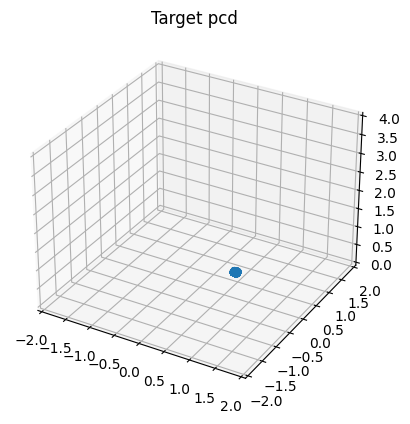

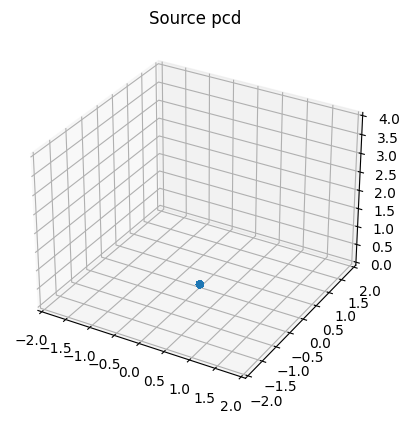

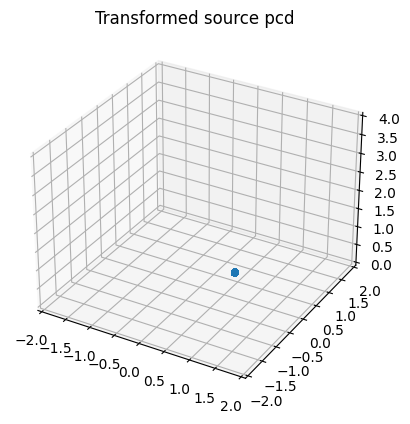

In [25]:
"""Visualization on comparing between test pose-transformed point clouds."""

source_pcd, target_pcd = test_pcd_source, test_pcd_target
print()
print(source_pcd.shape)
print(target_pcd.shape)
T = get_o3d_icp(source_pcd, target_pcd)
# print("GT T:")
# print(gt_T)
print("pred T:")
print(T)
# rre = np.rad2deg(compute_rre(T[:3, :3], gt_T[:3, :3]))
# rte = compute_rte(T[:3, 3], gt_T[:3, 3])
# print(f"rre={rre}, rte={rte}")
show_points(target_pcd, "Target pcd")
show_points(source_pcd, "Source pcd")
show_points(source_pcd @ T[:3, :3].T + T[:3, 3], "Transformed source pcd")



# Continual learning on pose estimation errors (on validation set)

In [26]:
"""ICP pose estimation on training set and error computations"""
# !mkdir train_outputs
!mkdir val_outputs

import numpy as np

# Flag for continuing from previous steps
ctu = False
ctu_variant, ctu_index = 0, 0
if ctu:
  ctu_variant, ctu_index = "1-1-4", 0

# file extractions
dataset_type = "val"
output_dir = "./{}_outputs".format(dataset_type)
rgb_files, depth_files, label_files, meta_files, prefix_ids = get_train_split_files(dataset_type)
print("{} size {}".format(dataset_type, len(depth_files)))

# For each object at each testing data: Get scene object's point cloud (as target pcd)
result_dict = {}
if ctu:
  json_path = os.path.join(output_dir, "result_till_{}_index_{}.json".format(ctu_variant, ctu_index))
  result_dict = load_json(json_path)


for i in range(ctu_index, len(depth_files)):
  train_depth_path, train_meta_path, train_label_path, train_prefix_id = depth_files[i], meta_files[i], label_files[i], prefix_ids[i]
  print("{} data id {}".format(dataset_type, train_prefix_id))
  train_meta, train_depth, train_seg_label = get_meta(train_meta_path), get_depth(train_depth_path), get_label(train_label_path)   # convert from mm to m
  intrinsic = train_meta["intrinsic"]
  extrinsic = train_meta["extrinsic"]
  scales = train_meta["scales"]
  inv_extrinsic = np.linalg.inv(extrinsic)
  result_dict[train_prefix_id] = {}
  result_dict[train_prefix_id]["poses_world"] = [None] * object_models_num
  # print(train_meta.keys())
  for object_id, object_name in zip(train_meta["object_ids"], train_meta["object_names"]):
    print("Object id {}, name {}".format(object_id, object_name))
    # mask the object's depth map to get train_object_depth
    # print(object_id, type(object_id))
    # print(train_image_label)
    train_image_label = train_seg_label.copy()

    # mask the object's depth map to get train_object_depth
    train_pcd_target = get_object_point_cloud(train_image_label, object_id, train_depth, intrinsic)

    # Fetch source point cloud from model dictionary and scale it
    train_pcd_source = object_models[object_name]
    train_pcd_source *= scales[object_id]
    # print(train_pcd_source.shape)
    # print(train_pcd_target.shape)

    # ICP to get posture
    # gt_T = train_meta["poses_world"]
    T = icp(train_pcd_source, train_pcd_target)
    T_world = inv_extrinsic @ T

    # update resulting dictionary with object id and pose list
    result_dict[train_prefix_id]["poses_world"][object_id] = T_world.tolist()
  output_name = "result_till_{}_index_{}.json".format(train_prefix_id, i)
  dump_json(result_dict, os.path.join(output_dir, output_name))

print("Test result:")
print(result_dict)
print(len(result_dict))



# Output resulting dictionary
output_name = "result.json"
dump_json(result_dict, os.path.join(output_dir, output_name))








val size 236
val data id 1-1-4
Object id 35, name jenga


100%|██████████| 50/50 [00:00<00:00, 285.72it/s]


Object id 39, name master_chef_can


100%|██████████| 50/50 [00:01<00:00, 40.78it/s]


Object id 48, name potted_meat_can


100%|██████████| 50/50 [00:01<00:00, 26.41it/s]


Object id 51, name pudding_box


100%|██████████| 50/50 [00:01<00:00, 49.75it/s]


Object id 58, name wood_block


100%|██████████| 50/50 [00:02<00:00, 21.82it/s]


val data id 1-1-15
Object id 35, name jenga


100%|██████████| 50/50 [00:00<00:00, 128.83it/s]


Object id 39, name master_chef_can


100%|██████████| 50/50 [00:03<00:00, 14.01it/s]


Object id 48, name potted_meat_can


100%|██████████| 50/50 [00:04<00:00, 10.66it/s]


Object id 51, name pudding_box


100%|██████████| 50/50 [00:00<00:00, 60.51it/s]


Object id 58, name wood_block


100%|██████████| 50/50 [00:00<00:00, 61.06it/s]


val data id 1-1-16
Object id 35, name jenga


100%|██████████| 50/50 [00:00<00:00, 217.24it/s]


Object id 39, name master_chef_can


100%|██████████| 50/50 [00:01<00:00, 34.41it/s]


Object id 48, name potted_meat_can


100%|██████████| 50/50 [00:01<00:00, 26.81it/s]


Object id 51, name pudding_box


100%|██████████| 50/50 [00:00<00:00, 68.23it/s]


Object id 58, name wood_block


100%|██████████| 50/50 [00:00<00:00, 61.58it/s]


val data id 1-2-18
Object id 35, name jenga


100%|██████████| 50/50 [00:00<00:00, 360.31it/s]


Object id 39, name master_chef_can


100%|██████████| 50/50 [00:01<00:00, 33.46it/s]


Object id 48, name potted_meat_can


100%|██████████| 50/50 [00:02<00:00, 19.17it/s]


Object id 51, name pudding_box


100%|██████████| 50/50 [00:01<00:00, 48.42it/s]


Object id 58, name wood_block


100%|██████████| 50/50 [00:01<00:00, 43.03it/s]


val data id 1-3-1
Object id 35, name jenga


100%|██████████| 50/50 [00:00<00:00, 159.88it/s]


Object id 39, name master_chef_can


100%|██████████| 50/50 [00:02<00:00, 19.67it/s]


Object id 48, name potted_meat_can


100%|██████████| 50/50 [00:04<00:00, 11.47it/s]


Object id 51, name pudding_box


100%|██████████| 50/50 [00:01<00:00, 37.39it/s]


Object id 58, name wood_block


100%|██████████| 50/50 [00:01<00:00, 38.92it/s]


val data id 1-3-3
Object id 35, name jenga


100%|██████████| 50/50 [00:00<00:00, 146.10it/s]


Object id 39, name master_chef_can


100%|██████████| 50/50 [00:01<00:00, 36.35it/s]


Object id 48, name potted_meat_can


100%|██████████| 50/50 [00:03<00:00, 16.49it/s]


Object id 51, name pudding_box


100%|██████████| 50/50 [00:02<00:00, 17.66it/s]


Object id 58, name wood_block


100%|██████████| 50/50 [00:01<00:00, 33.44it/s]


val data id 1-3-11
Object id 35, name jenga


100%|██████████| 50/50 [00:00<00:00, 280.99it/s]


Object id 39, name master_chef_can


100%|██████████| 50/50 [00:05<00:00,  9.85it/s]


Object id 48, name potted_meat_can


100%|██████████| 50/50 [00:05<00:00,  8.69it/s]


Object id 51, name pudding_box


100%|██████████| 50/50 [00:02<00:00, 24.72it/s]


Object id 58, name wood_block


100%|██████████| 50/50 [00:02<00:00, 19.66it/s]


val data id 1-4-10
Object id 35, name jenga


100%|██████████| 50/50 [00:00<00:00, 149.89it/s]


Object id 39, name master_chef_can


100%|██████████| 50/50 [00:01<00:00, 28.13it/s]


Object id 48, name potted_meat_can


100%|██████████| 50/50 [00:06<00:00,  7.58it/s]


Object id 51, name pudding_box


100%|██████████| 50/50 [00:01<00:00, 47.71it/s]


Object id 58, name wood_block


100%|██████████| 50/50 [00:01<00:00, 36.97it/s]


val data id 1-4-17
Object id 35, name jenga


100%|██████████| 50/50 [00:00<00:00, 200.71it/s]


Object id 39, name master_chef_can


100%|██████████| 50/50 [00:01<00:00, 38.53it/s]


Object id 48, name potted_meat_can


100%|██████████| 50/50 [00:02<00:00, 23.73it/s]


Object id 51, name pudding_box


100%|██████████| 50/50 [00:00<00:00, 83.78it/s]


Object id 58, name wood_block


100%|██████████| 50/50 [00:00<00:00, 54.75it/s]


val data id 1-5-11
Object id 35, name jenga


100%|██████████| 50/50 [00:00<00:00, 279.38it/s]


Object id 39, name master_chef_can


100%|██████████| 50/50 [00:01<00:00, 38.88it/s]


Object id 48, name potted_meat_can


100%|██████████| 50/50 [00:02<00:00, 21.19it/s]


Object id 51, name pudding_box


100%|██████████| 50/50 [00:00<00:00, 64.12it/s]


Object id 58, name wood_block


100%|██████████| 50/50 [00:01<00:00, 34.23it/s]


val data id 1-5-19
Object id 35, name jenga


100%|██████████| 50/50 [00:00<00:00, 167.48it/s]


Object id 39, name master_chef_can


100%|██████████| 50/50 [00:01<00:00, 25.45it/s]


Object id 48, name potted_meat_can


100%|██████████| 50/50 [00:03<00:00, 13.68it/s]


Object id 51, name pudding_box


100%|██████████| 50/50 [00:01<00:00, 49.28it/s]


Object id 58, name wood_block


100%|██████████| 50/50 [00:00<00:00, 59.81it/s]


val data id 1-6-2
Object id 35, name jenga


100%|██████████| 50/50 [00:00<00:00, 361.12it/s]


Object id 39, name master_chef_can


100%|██████████| 50/50 [00:01<00:00, 36.36it/s]


Object id 48, name potted_meat_can


100%|██████████| 50/50 [00:02<00:00, 19.30it/s]


Object id 51, name pudding_box


100%|██████████| 50/50 [00:00<00:00, 75.80it/s]


Object id 58, name wood_block


100%|██████████| 50/50 [00:00<00:00, 70.62it/s]


val data id 1-6-5
Object id 35, name jenga


100%|██████████| 50/50 [00:00<00:00, 288.46it/s]


Object id 39, name master_chef_can


100%|██████████| 50/50 [00:01<00:00, 33.64it/s]


Object id 48, name potted_meat_can


100%|██████████| 50/50 [00:02<00:00, 20.24it/s]


Object id 51, name pudding_box


100%|██████████| 50/50 [00:01<00:00, 44.92it/s]


Object id 58, name wood_block


100%|██████████| 50/50 [00:01<00:00, 36.43it/s]


val data id 1-6-13
Object id 35, name jenga


100%|██████████| 50/50 [00:00<00:00, 238.64it/s]


Object id 39, name master_chef_can


100%|██████████| 50/50 [00:02<00:00, 24.05it/s]


Object id 48, name potted_meat_can


100%|██████████| 50/50 [00:01<00:00, 25.22it/s]


Object id 51, name pudding_box


100%|██████████| 50/50 [00:00<00:00, 80.88it/s]


Object id 58, name wood_block


100%|██████████| 50/50 [00:00<00:00, 68.02it/s]


val data id 1-7-6
Object id 35, name jenga


100%|██████████| 50/50 [00:00<00:00, 262.58it/s]


Object id 39, name master_chef_can


100%|██████████| 50/50 [00:01<00:00, 40.49it/s]


Object id 48, name potted_meat_can


100%|██████████| 50/50 [00:01<00:00, 27.19it/s]


Object id 51, name pudding_box


100%|██████████| 50/50 [00:00<00:00, 79.17it/s]


Object id 58, name wood_block


100%|██████████| 50/50 [00:00<00:00, 60.60it/s]


val data id 1-7-7
Object id 35, name jenga


100%|██████████| 50/50 [00:00<00:00, 290.98it/s]


Object id 39, name master_chef_can


100%|██████████| 50/50 [00:01<00:00, 40.63it/s]


Object id 48, name potted_meat_can


100%|██████████| 50/50 [00:04<00:00, 10.81it/s]


Object id 51, name pudding_box


100%|██████████| 50/50 [00:01<00:00, 42.41it/s]


Object id 58, name wood_block


100%|██████████| 50/50 [00:01<00:00, 38.97it/s]


val data id 1-8-1
Object id 35, name jenga


100%|██████████| 50/50 [00:00<00:00, 219.96it/s]


Object id 39, name master_chef_can


100%|██████████| 50/50 [00:02<00:00, 23.99it/s]


Object id 48, name potted_meat_can


100%|██████████| 50/50 [00:02<00:00, 23.02it/s]


Object id 51, name pudding_box


100%|██████████| 50/50 [00:00<00:00, 79.87it/s]


Object id 58, name wood_block


100%|██████████| 50/50 [00:00<00:00, 62.78it/s]


val data id 1-9-4
Object id 35, name jenga


100%|██████████| 50/50 [00:00<00:00, 400.96it/s]


Object id 39, name master_chef_can


100%|██████████| 50/50 [00:01<00:00, 40.22it/s]


Object id 48, name potted_meat_can


100%|██████████| 50/50 [00:02<00:00, 23.39it/s]


Object id 51, name pudding_box


100%|██████████| 50/50 [00:00<00:00, 80.36it/s]


Object id 58, name wood_block


100%|██████████| 50/50 [00:00<00:00, 58.18it/s]


val data id 1-9-9
Object id 35, name jenga


100%|██████████| 50/50 [00:00<00:00, 307.41it/s]


Object id 39, name master_chef_can


100%|██████████| 50/50 [00:01<00:00, 34.39it/s]


Object id 48, name potted_meat_can


100%|██████████| 50/50 [00:03<00:00, 14.42it/s]


Object id 51, name pudding_box


100%|██████████| 50/50 [00:01<00:00, 44.62it/s]


Object id 58, name wood_block


100%|██████████| 50/50 [00:01<00:00, 40.25it/s]


val data id 1-12-2
Object id 39, name master_chef_can


100%|██████████| 50/50 [00:02<00:00, 24.70it/s]


Object id 51, name pudding_box


100%|██████████| 50/50 [00:00<00:00, 61.66it/s]


Object id 52, name rubiks_cube


100%|██████████| 50/50 [00:01<00:00, 27.07it/s]


Object id 57, name tuna_fish_can


100%|██████████| 50/50 [00:00<00:00, 72.73it/s]


Object id 58, name wood_block


100%|██████████| 50/50 [00:00<00:00, 58.90it/s]


val data id 1-13-7
Object id 39, name master_chef_can


100%|██████████| 50/50 [00:01<00:00, 36.31it/s]


Object id 51, name pudding_box


100%|██████████| 50/50 [00:00<00:00, 74.22it/s]


Object id 52, name rubiks_cube


100%|██████████| 50/50 [00:01<00:00, 31.96it/s]


Object id 57, name tuna_fish_can


100%|██████████| 50/50 [00:00<00:00, 85.72it/s]


Object id 58, name wood_block


100%|██████████| 50/50 [00:00<00:00, 53.59it/s]


val data id 1-13-11
Object id 39, name master_chef_can


100%|██████████| 50/50 [00:02<00:00, 24.51it/s]


Object id 51, name pudding_box


KeyboardInterrupt: ignored

# Visualization of validation pcds

In [ ]:
"""Generate gt result.json for validation map"""
from tqdm import tqdm
result = {}


for j in tqdm(range(len(meta_files))):
  meta = get_meta(meta_files[j])
  id = prefix_ids[j]
  pose_l = meta["poses_world"]
  for i in range(len(pose_l)):
    if pose_l[i] is not None:
      pose_l[i] = pose_l[i].tolist()
  result[id] = {}
  result[id]["poses_world"] = pose_l

# print(result)
# print(result)
dump_json(result, "./result_val.json")




In [ ]:
!cp result_val.json ./drive/MyDrive/

dict_keys(['poses_world', 'extents', 'scales', 'object_ids', 'object_names', 'extrinsic', 'intrinsic'])
(4, 4)
master_chef_can
:: Load two point clouds and disturb initial pose.
:: Downsample with a voxel size 0.050.
:: Estimate normal with search radius 0.100.
:: Compute FPFH feature with search radius 0.250.
:: Downsample with a voxel size 0.050.
:: Estimate normal with search radius 0.100.
:: Compute FPFH feature with search radius 0.250.
:: RANSAC registration on downsampled point clouds.
   Since the downsampling voxel size is 0.050,
   we use a liberal distance threshold 0.075.
RegistrationResult with fitness=0.000000e+00, inlier_rmse=0.000000e+00, and correspondence_set size of 0
Access transformation to get result.
:: Point-to-plane ICP registration is applied on original point
   clouds to refine the alignment. This time we use a strict
   distance threshold 0.020.
RegistrationResult with fitness=0.000000e+00, inlier_rmse=0.000000e+00, and correspondence_set size of 0
Access t

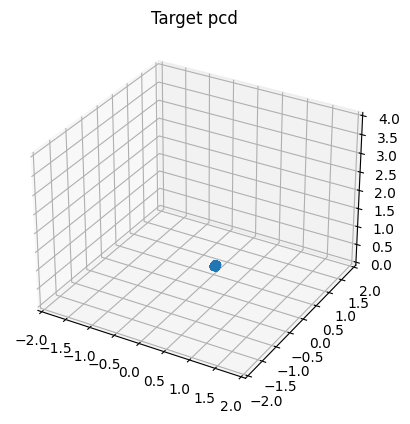

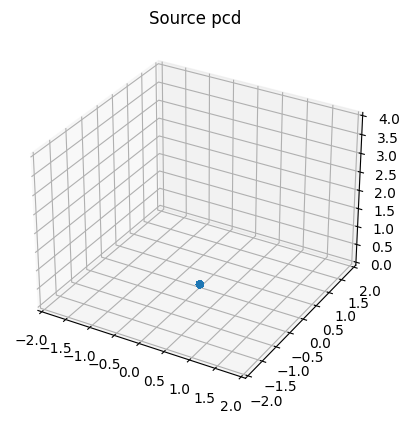

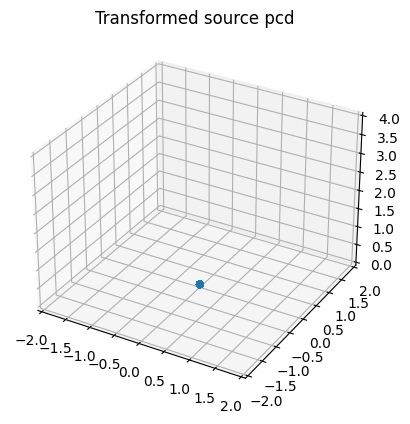

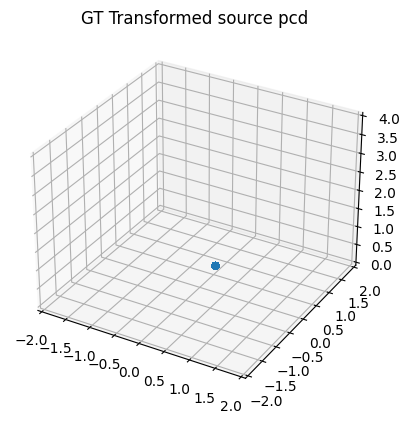

In [40]:
"""Visualization on comparing between train pose-transformed point clouds."""
import open3d as o3d
import time
import copy

def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp],
                                      zoom=0.4559,
                                      front=[0.6452, -0.3036, -0.7011],
                                      lookat=[1.9892, 2.0208, 1.8945],
                                      up=[-0.2779, -0.9482, 0.1556])

def preprocess_point_cloud(pcd, voxel_size):
    print(":: Downsample with a voxel size %.3f." % voxel_size)
    pcd_down = pcd.voxel_down_sample(voxel_size)

    radius_normal = voxel_size * 2
    print(":: Estimate normal with search radius %.3f." % radius_normal)
    pcd_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))

    radius_feature = voxel_size * 5
    print(":: Compute FPFH feature with search radius %.3f." % radius_feature)
    pcd_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
        pcd_down,
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100))
    return pcd_down, pcd_fpfh

def prepare_dataset(voxel_size, source, target):
    print(":: Load two point clouds and disturb initial pose.")

    trans_init = np.asarray([[0.0, 0.0, 1.0, 0.0], [1.0, 0.0, 0.0, 0.0],
                             [0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0]])
    source.transform(trans_init)

    source_down, source_fpfh = preprocess_point_cloud(source, voxel_size)
    target_down, target_fpfh = preprocess_point_cloud(target, voxel_size)
    return source, target, source_down, target_down, source_fpfh, target_fpfh

def execute_global_registration(source_down, target_down, source_fpfh,
                                target_fpfh, voxel_size):
  distance_threshold = voxel_size * 1.5
  print(":: RANSAC registration on downsampled point clouds.")
  print("   Since the downsampling voxel size is %.3f," % voxel_size)
  print("   we use a liberal distance threshold %.3f." % distance_threshold)
  result = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
      source_down, target_down, source_fpfh, target_fpfh, True,
      distance_threshold,
      o3d.pipelines.registration.TransformationEstimationPointToPoint(False),
      3, [
          o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(
              0.9),
          o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(
              distance_threshold)
      ], o3d.pipelines.registration.RANSACConvergenceCriteria(100000, 0.999))
  return result

def execute_fast_global_registration(source_down, target_down, source_fpfh, target_fpfh, voxel_size):
  distance_threshold = voxel_size * 0.5
  print(":: Apply fast global registration with distance threshold %.3f" \
          % distance_threshold)
  result = o3d.pipelines.registration.registration_fgr_based_on_feature_matching(
      source_down, target_down, source_fpfh, target_fpfh,
      o3d.pipelines.registration.FastGlobalRegistrationOption(
          maximum_correspondence_distance=distance_threshold))
  return result

def refine_registration(source, target, source_fpfh, target_fpfh, voxel_size, init):
    distance_threshold = voxel_size * 0.4
    print(":: Point-to-plane ICP registration is applied on original point")
    print("   clouds to refine the alignment. This time we use a strict")
    print("   distance threshold %.3f." % distance_threshold)
    result = o3d.pipelines.registration.registration_icp(
        source, target, distance_threshold, init,
        o3d.pipelines.registration.TransformationEstimationPointToPlane())
    return result

def get_o3d_icp_with_global_registration(source_pcd, target_pcd):
  source_pcd_o3d, target_pcd_o3d = o3d.geometry.PointCloud(), o3d.geometry.PointCloud()
  source_pcd_o3d.points = o3d.utility.Vector3dVector(source_pcd)
  target_pcd_o3d.points = o3d.utility.Vector3dVector(target_pcd)
  voxel_size = 10  # means 5cm for this dataset
  source, target, source_down, target_down, source_fpfh, target_fpfh = prepare_dataset(voxel_size, source_pcd_o3d, target_pcd_o3d)
  result_ransac = execute_global_registration(source_down, target_down, \
                        source_fpfh, target_fpfh, \
                        voxel_size)
  print(result_ransac)
  result_icp = refine_registration(source_down, target_down, source_fpfh, target_fpfh, voxel_size, result_ransac.transformation)
  print(result_icp)
  draw_registration_result(source_down, target_down, result_icp.transformation)
  return result_icp.transformation

def get_o3d_icp_tensor(source_pcd, target_pcd):
  # T = icp(source_pcd, target_pcd, 150)
  source_pcd_o3d, target_pcd_o3d = o3d.t.geometry.PointCloud(), o3d.t.geometry.PointCloud()
  # print(source_pcd)
  source_pcd_o3d.point.positions = o3d.core.Tensor(source_pcd, dtype=o3d.core.Dtype.Float64)
  # source_pcd_o3d.estimate_normals(o3d.geometry.KDTreeSearchParamKNN(knn=50))
  target_pcd_o3d.point.positions = o3d.core.Tensor(target_pcd, dtype=o3d.core.Dtype.Float64)
  # Search distance for Nearest Neighbour Search [Hybrid-Search is used].
  max_correspondence_distance = 1
  init = o3d.core.Tensor.eye(4, o3d.core.Dtype.Float64)
  # Select the `Estimation Method`, and `Robust Kernel` (for outlier-rejection).
  treg = o3d.cpu.pybind.t.pipelines.registration
  estimation = treg.TransformationEstimationPointToPoint()
  callback_after_iteration = lambda updated_result_dict : print("Iteration Index: {}, Fitness: {}, Inlier RMSE: {},".format(
    updated_result_dict["iteration_index"].item(), \
    updated_result_dict["fitness"].item(), \
    updated_result_dict["inlier_rmse"].item())) \

  # Convergence-Criteria for Vanilla ICP
  criteria = treg.ICPConvergenceCriteria(relative_fitness=0.0000000000001,
                      relative_rmse=0.0000000000001,
                      max_iteration=100)

  # Down-sampling voxel-size.
  # voxel_size = 0.0016625
  # voxel_size = 0.003125
  voxel_size = 0.00625
  # voxel_size = 0.0125

  # Save iteration wise `fitness`, `inlier_rmse`, etc. to analyse and tune result.
  save_loss_log = True
  s = time.time()

  # voxel_size = 0.05  # means 5cm for this dataset
  # source, target, source_down, target_down, source_fpfh, target_fpfh = prepare_dataset(voxel_size, source_pcd_o3d, target_pcd_o3d)
  # result_ransac = execute_global_registration(source_down, target_down, source_fpfh, target_fpfh, voxel_size)
  # init = o3d.core.Tensor(result_ransac.transformation, dtype=o3d.core.Dtype.Float64)

  registration_icp = treg.icp(source_pcd_o3d, target_pcd_o3d, max_correspondence_distance, init, estimation, criteria, voxel_size, callback_after_iteration)
  icp_time = time.time() - s
  T = registration_icp.transformation
  T = T.numpy()
  return T


def get_o3d_icp(source_pcd, target_pcd):
  # T = icp(source_pcd, target_pcd, 150)
  source_pcd_o3d, target_pcd_o3d = o3d.geometry.PointCloud(), o3d.geometry.PointCloud()
  # print(source_pcd)
  source_pcd_o3d.points = o3d.utility.Vector3dVector(source_pcd)
  # source_pcd_o3d.estimate_normals(o3d.geometry.KDTreeSearchParamKNN(knn=50))
  target_pcd_o3d.points = o3d.utility.Vector3dVector(target_pcd)
  # print(source_pcd_o3d)
  # print(target_pcd_o3d)
  # target_pcd_o3d.estimate_normals(o3d.geometry.KDTreeSearchParamKNN(knn=50))
  init = np.eye(4)
  # init[0,0] = 2
  T = o3d.pipelines.registration.registration_icp( \
        source_pcd_o3d, target_pcd_o3d, 5, init, \
        o3d.pipelines.registration.TransformationEstimationPointToPoint(), \
        o3d.pipelines.registration.ICPConvergenceCriteria(relative_fitness=0.00000001, \
                                 relative_rmse=0.00000001, \
                                 max_iteration=500))
  # T = icp(source_pcd, target_pcd)
  # print(T.inlier_rmse)
  # print(T.fitness)
  # print(T.correspondence_set)
  T = T.transformation
  return T

# Define the data point to visualize
train_vis_varianct, train_vis_index, object_ids, vis_id = "1-1-4", 0, [35, 39, 48, 51, 58], 39
rgb_files, depth_files, label_files, meta_files, prefix_ids


# Load scene meta info
meta_vis = get_meta(meta_files[train_vis_index])
print(meta_vis.keys())
intrinsic = meta_vis["intrinsic"]
extrinsic = meta_vis["extrinsic"]
inv_extrinsic = np.linalg.inv(extrinsic)
gt_T_world = meta_vis["poses_world"][vis_id]
gt_T = extrinsic @ gt_T_world
scales = meta_vis["scales"]
print(gt_T.shape)
# gt_T = meta_vis["poses_world"][vis_id]
# Fetch source point cloud from model dictionary
# print(object_models)


# Reconstruct source and target point clouds (in camera frame)
print(object_name)
object_name = object_models_name[vis_id]
vis_pcd_source = object_models[object_name]
vis_pcd_source = vis_pcd_source * scales[vis_id]
vis_pcd_target = get_object_point_cloud(get_label(label_files[train_vis_index]), \
                    vis_id, \
                    get_depth(depth_files[train_vis_index]), \
                    intrinsic)


# Perform ICP
# source_pcd, target_pcd = vis_pcd_target, vis_pcd_source
source_pcd, target_pcd = vis_pcd_source, vis_pcd_target
# source_pcd = np.hstack((source_pcd, np.ones((len(source_pcd), 1))))
# target_pcd = np.hstack((target_pcd, np.ones((len(target_pcd), 1))))
# source_pcd, target_pcd = (source_pcd @ np.linalg.inv(extrinsic).T), (target_pcd @ np.linalg.inv(extrinsic).T)
# source_pcd = np.array([x[:-1]/x[-1] for x in source_pcd])
# target_pcd = np.array([x[:-1]/x[-1] for x in target_pcd])
# print(source_pcd.shape, target_pcd.shape)
T = get_o3d_icp_with_global_registration(source_pcd, target_pcd)
# T = get_o3d_icp_tensor(source_pcd, target_pcd)
# T = get_o3d_icp(source_pcd, target_pcd)
# T = icp(source_pcd, target_pcd, 100)
T_world = inv_extrinsic @ T



# T = np.eye(4)
print(source_pcd.shape)
print(target_pcd.shape)
print("GT T:")
print(gt_T)
print("GT T world:")
print(gt_T_world)
print("pred T:")
print(T)
print("pred T world:")
print(T_world)
# rre = np.rad2deg(compute_rre(T[:3, :3], gt_T[:3, :3]))
# rte = compute_rte(T[:3, 3], gt_T[:3, 3])
rre = np.rad2deg(compute_rre(T_world[:3, :3], gt_T_world[:3, :3]))
rte = compute_rte(T_world[:3, 3], gt_T_world[:3, 3])
print(f"rre={rre}, rte={rte}")
show_points(target_pcd, "Target pcd")
show_points(source_pcd, "Source pcd")
show_points(source_pcd @ T[:3, :3].T + T[:3, 3], "Transformed source pcd")
show_points(source_pcd @ gt_T[:3, :3].T + gt_T[:3, 3], "GT Transformed source pcd")






In [28]:
import open3d as o3d

demo_icp_pcds = o3d.data.DemoICPPointClouds()
source = o3d.io.read_point_cloud(demo_icp_pcds.paths[0])
target = o3d.io.read_point_cloud(demo_icp_pcds.paths[1])
# print(source)
# print(source.points)
# print(np.asarray(source.points))
trans_init = np.asarray([[0.0, 0.0, 1.0, 0.0], [1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0]])
source.transform(trans_init)


PointCloud with 198835 points.
std::vector<Eigen::Vector3d> with 198835 elements.
Use numpy.asarray() to access data.
[[1.01953125 0.88671875 2.27726722]
 [1.04296875 0.88671875 2.27699804]
 [1.05859375 0.88671875 2.27722216]
 ...
 [1.26609075 2.37890625 2.26171875]
 [1.26171875 2.38015151 2.26171875]
 [1.26171875 2.37890625 2.26367211]]


PointCloud with 198835 points.